<a href="https://colab.research.google.com/github/l-monninger/ahl/blob/main/ahl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AHL: Matching Patents to Scientific Papers
In this Colab notebook, we will be walking through our team's endeavors to provide a model for **matching patents with scientific papers.** 

This project refers to itself as AHL, after the first initals of our contributors names.

## Motivation
The original motivation behind this project was to create a recommendation system that **given a patent would recommend a list of scientific papers, and vice versa.** We anticipated this could serve as the first steps in development of a tool that would be useful for researchers, technologists, and practitioners of patent law.

## Data
Our results are derived from https://www.kaggle.com/datasets/Cornell-University/arxiv and https://www.kaggle.com/datasets/jackchungchiehyu/big-patent.

Though the exploration is not included herein due to its runtime, we determined that each of these datasets individually has cardinalities of over 2 million and contains over 1 billion text tokens. We estimate that we've process over 20 GB of data. Ths size of this data resulted in many difficulties while training our models and while forming this final notebook, as discussed below. 

## Difficulties
Difficulties encountered primarily stemmed from the **size of the data** with respect to the processing attempted. Our greedy methods required an expensive Cartesian product. Our regressive methods required a large number of input features. And, when recommending, we used naive algorithms that required full reprojection of the data.

Difficulties at scale noted, we will generally be operating over random samples of the data in this notebook. We will also else rely on lazy and generator patterns evaluation to avoid high runtimes and RAM usage.

## Exploration
Our exploration features a brief section on the limitations of embedding followed by token based-analysis. We provide the preliminaries for our token matching model in the exploration, reporting confusion matrices for several first-order joins on intersecting tokens.

Further exploration can be found in the in our GitHub repo: https://github.com/ahl-big-data/ahl

## Models
We provide four models, `TokensToTokens`, `SbertAvg`, `AhlEmbeddingAvg`, and `SbertExCnn`. 

More extensive versions of the models can be found in https://github.com/ahl-big-data/ahl under packages/ahlpy/models.

### `TokensToTokens`
`TokensToTokens` is a simple first-order BFS matching algorithm that uses the tokens from the abstracts of both patents and papers. 

Results of this model are used to underscore the limited cross-media validity of the scoring provided in the exploration section. That is, the cursory evaluation of the model based upon joining papers to papers may have indicated high enough specificity. However, human evaluation of this model in the multi-media setting indicates that is expectedly unsuited for a matching with material outside of the scientific literature.

### `SbertAvg`
`SbertAvg` is the most persuasive as a model for recommending patents from papers. The model consistently produces compelling matches between the two media.

Randomly sampled human evaluation of this model discovered a specificity of 73.2%.

### `AhlEmbeddingAvg`
`AhlEmbeddingAvg` is constructed in the same manner as `SbertAvg`, but instead uses the abstracts from `papers` and `patents` to compute its own embeddings.

Randomly sampled human evaluation of this model discovered a specificity of 68.9%.

### `SbertExCnn`
`SbertExCnn` is an attempt to rebuild `Sbert` as an end-to-end model operating on up to 4096 character codes across multiple sentences. It is unlikely this will successfully train when you run this notebook, and preliminary trainings elsewhere indicate it is an expensive to reproduce the `Sbert` model.

## Application
A demo frontend for the resulting models was deployed at https://patp2pat.com. However, costs were too significant in the naive deployment to maintain it. If a better hosting solution is determined, the site will be redeployed at this address.

## Next Steps
Further development of these models would likely need to begin with an upgrade in underlying infrastructure and greater time commitment. It proved very difficult to train the large embedding models on Colab and our local machines. 

More than likely, significant gains could still be had by means of embedding.

The only serious models bases for models this report are likely `SbertAvg` and `AhlEmbeddingAvg`. Efforts to improve core embeddings as well as to move away from embedding average to something more respective of sentence structure would likely be ideal first steps.

## Requirements

### Installations

In [1]:
# Installation 
!pip install kaggle
!pip install pyspark
!pip install feedparser
!pip install torch
!pip install sentence-transformers
!pip install numpy
!pip install rake-nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=6eb3c278b10eacff6c5d4cdc8cd62c2008554f4b43ae8803bb2050bfdc38ea3a
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=541b86dc3e33a65094eb878154e5323e0b1fc85029b4eef737bc577987615a3c
  Stored in

### Encoding

In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### Libraries

In [3]:
# libraries
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import * 
import requests
from lxml import etree
import nltk
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from rake_nltk import Rake
import csv
import seaborn as sns

#import libraries for knowledge graph
import re
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
from tqdm import tqdm
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from collections import Counter
from typing import *

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer

### Mount on Drive

In [4]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle

Mounted at /content/drive


### Configure Kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

### Configure Spark

In [6]:
# start sparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()

### GPU


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Common Helper Funcs


#### Tokenization

##### NLTK Dependencies

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

##### Stopwords

In [9]:
stopwords : set[str] = set(nltk.corpus.stopwords.words('english'))

def tokenize_non_stopwords(content : str)->list[str]:
  """Tokenizes content excluding the stopwords.

  Args:
      content (str): _description_

  Returns:
      list[str]: _description_
  """
  tokens = nltk.word_tokenize(content)
  words = [
      token.lower() 
      for token in tokens 
      if token.isalpha() and token.lower() not in stopwords
  ]
  return words

In [10]:
tokenize_non_stopwords_udf = udf(tokenize_non_stopwords, ArrayType(StringType()))

##### Sentences

In [11]:
def tokenize_sentences(content : str)->list[str]:
  """Tokenizes sentences.

  Args:
      content (str): _description_

  Returns:
      list[str]: _description_
  """
  return nltk.sent_tokenize(content)

In [12]:
tokenize_sentences_udf = udf(tokenize_sentences, ArrayType(StringType()))

##### Named entities

In [13]:
def get_named_entities_in_sentence(sentence):
  chunked = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sentence)))
  return [ 
      " ".join(w for w, t in elt) 
      for elt in chunked if isinstance(elt, nltk.Tree) 
  ]

def get_named_entities(content):
  sentences = tokenize_sentences(content)
  sentence_nes = [get_named_entities_in_sentence(sentence) for sentence in sentences]
  return [ne for nes in sentence_nes for ne in nes]

In [14]:
get_named_entities_udf = udf(get_named_entities, ArrayType(StringType()))

##### Rake

In [15]:
def get_rake(content, *, min_len : int = 3):
  r = Rake()
  r.extract_keywords_from_text(content)
  keywords = r.get_ranked_phrases()
  words = [
    token.lower() 
    for token in keywords 
      if token.isalpha() and token.lower() not in stopwords and len(token)>= min_len
  ]
  return words

In [16]:
get_rake_udf = udf(get_rake, ArrayType(StringType()))

##### Top tokens

In [17]:
def get_top_tokens(tokens, *, size : int = 10):
  return [
      token
      for token, _ in Counter(tokens).most_common(size)
  ]

In [18]:
tokenize_top_10_udf = udf(get_top_tokens, ArrayType(StringType()))

#### Ngrams


In [19]:
Ngram = Tuple[Tuple[str], str]

##### Prefix ngrams

In [20]:
def get_sequence_prefix_ngrams(*,
    seq : Sequence,
    context_size : int,
)->Iterable[Ngram]:

  for i in range(context_size, len(seq)):
      yield  (
          [seq[i - j - 1] for j in range(context_size)],
          seq[i]
      )

def get_text_prefix_ngrams(*, 
  text: str, 
  context_size: int, 
  tokenize : Callable[[str], Iterable[str]] = tokenize_non_stopwords
) -> Iterable[Ngram]:
        
  sentence = tokenize(text)
  
  for ngram in get_sequence_prefix_ngrams(
    seq = sentence,
    context_size = context_size
  ): yield ngram

In [21]:
assert list(get_text_prefix_ngrams(
    text="Hello, my name is Liam.",
    context_size=2,
)) == [(['name', 'hello'], 'liam')]

##### Excluding ngrams

In [22]:
def sequence_excluding(*,
    seq : Sequence,
    excluding_pos : int,
    context_size : int,
    fill_term : Any       
):

  context = []
  i = excluding_pos - context_size

  while i < 0: 
    context.append(fill_term)
    i+=1

  while i < excluding_pos and i < len(seq):
    context.append(seq[i])
    i +=1
  i+=1

  while i < len(seq):
    context.append(seq[i])
    i += 1

  while len(context) < 2 * context_size:
    context.append(fill_term)
    i+=1

  return context[0:2*context_size]
  

def get_sequence_excludes_ngrams(*,
    seq : Sequence,
    context_size : int,
    fill_term : Any  
)->Iterable[Ngram]:

  for i in range(0, len(seq)):
      yield  (
          sequence_excluding(
              seq = seq,
              excluding_pos = i,
              context_size = context_size,
              fill_term = fill_term
          ),
          seq[i]
      )

def get_text_excludes_ngrams(*, 
  text: str, 
  context_size: int, 
  tokenize : Callable[[str], Iterable[str]] = tokenize_non_stopwords,
  fill_term : str = ""
) -> Iterable[Ngram]:
        
  sentence = tokenize(text)
  
  for ngram in get_sequence_excludes_ngrams(
    seq = sentence,
    context_size = context_size,
    fill_term=fill_term
  ): yield ngram


In [23]:
assert list(get_text_excludes_ngrams(
    text="Hello, my name is Liam.",
    context_size=2,
)) == [(['', '', 'name', 'liam'], 'hello'),
 (['', 'hello', 'liam', ''], 'name'),
 (['hello', 'name', '', ''], 'liam')]

##### Default ngram embedding model

In [24]:
class NgramModel(nn.Module):
        
    def __init__(self, *, vocab_size : int, embedding_dim : int, context_size : int):
        super(NgramModel, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.activate = nn.Sequential(
            self.embeddings,
            nn.Flatten(0),
            nn.Linear(context_size * embedding_dim, 128),
            nn.ReLU(), # first
            nn.Linear(128, vocab_size),
            nn.LogSoftmax(0),
            nn.Unflatten(0, (1, vocab_size))
        )
        
    def forward(self, inputs):
        return self.activate(inputs)

#### Vocabulary


A vocabulary is a mapping from words to contiguous indices and back to words.

In [25]:
Vocab = Tuple[Dict[Any, int], Dict[int, Any]]

##### Corpus

In [26]:
def corpus_to_words(*, 
      texts: Iterable[str],
      tokenize_sentences : Callable[[str], Iterable[str]] = tokenize_sentences,
      tokenize_words : Callable[[str], Iterable[str]] = tokenize_non_stopwords
)->Iterable[str]:

  for text in texts:
      for s in tokenize_sentences(text):
        sentence = tokenize_words(text)
        for word in sentence: yield word

In [27]:
assert list(corpus_to_words(texts=[
    "Liam runs to the store.",
    "Liam finds an egg.",
    "Liam cooks the egg."
])) == ['liam', 'runs', 'store', 'liam', 'finds', 'egg', 'liam', 'cooks', 'egg']

##### All word vocabulary

In [28]:
def get_texts_vocab(*, 
      texts: Iterable[str],
      tokenize_sentences : Callable[[str], Iterable[str]] = tokenize_sentences,
      tokenize_words : Callable[[str], Iterable[str]] = tokenize_non_stopwords
) -> Vocab:
        
  vocab = { "" : 0}
  pos = 1
  for text in texts:
      for s in tokenize_sentences(text):

          sentence = tokenize_non_stopwords(text)
          # add individual words to vocab
          for word in sentence:
              if word in vocab:
                  continue
              vocab[word] = pos
              pos += 1
              
  inv_vocab = {v: k for k, v in vocab.items()}
  return (vocab, inv_vocab)

In [29]:
assert list(get_texts_vocab(texts=[
    "Liam runs to the store.",
    "Liam finds an egg.",
    "Liam cooks the egg."
])) == [{'': 0, 'liam': 1, 'runs': 2, 'store': 3, 'finds': 4, 'egg': 5, 'cooks': 6},
 {0: '', 1: 'liam', 2: 'runs', 3: 'store', 4: 'finds', 5: 'egg', 6: 'cooks'}]

##### Top word vocabulary

In [30]:
def get_texts_top_vocab(*, 
      texts: Iterable[str],
      size : int = 1_000, 
      tokenize_sentences : Callable[[str], Iterable[str]] = tokenize_sentences,
      tokenize_words : Callable[[str], Iterable[str]] = tokenize_non_stopwords,
) -> Vocab:
        
  top_tokens = get_top_tokens(corpus_to_words(
      texts=texts,
      tokenize_sentences=tokenize_sentences,
      tokenize_words=tokenize_words
    ), size=size)
 
  vocab = { "" : 0}
  for i, token in enumerate(top_tokens): vocab[token] = i + 1
              
  inv_vocab = {v: k for k, v in vocab.items()}
  return (vocab, inv_vocab)

In [31]:
assert list(get_texts_top_vocab(texts=[
    "Liam runs to the store.",
    "Liam finds an egg.",
    "Liam cooks the egg."
], size=2)) == [{'' : 0, 'liam': 1, 'egg': 2}, {0 : '', 1: 'liam', 2: 'egg'}]

#### Filling and slicing

In [32]:
def flice_text(text : str, *,  max_length : int, fill_str : str)->str:
    
    if len(text) >= max_length:
        return text[0:max_length]
    
    cpy = text
    while len(cpy) < max_length:
        cpy += fill_str
    return cpy

def flice_list(text : List[Any], *,  max_length : int, fill_term : Any)->List[Any]:
    
    if len(text) >= max_length:
        return text[0:max_length]
    
    cpy = text
    while len(cpy) < max_length:
        cpy.append(fill_term)
    return cpy

#### Embedding

##### Ngram embedding

In [33]:
Embedding = Callable[[Any], torch.FloatTensor]

In [34]:
def train_ngram_embedding(
    *, 
    epochs : int = 10,
    embedding_dim : int = 32,
    context_size : int = 3,
    ngrams : Callable[[], Iterable[Ngram]],
    vocab : Vocab
)->Tuple[Embedding, List[float]]:
  
        vocab_forward, vocab_reverse = vocab
        losses = []
        
        # model
        loss_function = nn.NLLLoss()
        model = NgramModel(
            vocab_size=len(vocab_forward), 
            embedding_dim=embedding_dim, 
            context_size=context_size
        )
        optimizer = optim.SGD(model.parameters(), lr=0.001)

        # train
        for epoch in range(epochs):
    
            epoch_loss = 0
            i = 0
            for context, target in ngrams():

                i+=1
                # words to indices
                context_idxs = torch.tensor([vocab_forward[w] for w in context], dtype=torch.long)

                # zero out the gradient
                model.zero_grad()

                # forward pass
                log_probs = model(context_idxs)

                # loss
                loss = loss_function(log_probs, torch.tensor([vocab_forward[target]], dtype=torch.long))

                # backward pass
                loss.backward()
                optimizer.step()

                # Get the Python number from a 1-element Tensor by calling tensor.item()
                epoch_loss += loss.item()
            losses.append(epoch_loss)

        # factory
        def embedding(input : Any)->torch.FloatTensor():
          # try:
          return model.embeddings.weight[vocab_forward[input]]
          # except Exception as e:
          # return torch.zeros(embedding_dim)

        sim = nn.CosineSimilarity()
        # values, indices = sim(model.embeddings.weight[vocab["data"]], model.embeddings.weight).sort(descending=True)

        return (embedding, losses, model, model.embeddings.weight)

## Data Wrangling

### Download and Spark frames

##### Papers

In [35]:
!kaggle datasets download -d Cornell-University/arxiv --force
!unzip -o /content/arxiv.zip

100% 1.14G/1.14G [00:46<00:00, 29.4MB/s]
100% 1.14G/1.14G [00:46<00:00, 26.5MB/s]
Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [36]:
arxiv_sdf = spark.read.json("arxiv-metadata-oai-snapshot.json", multiLine = False, primitivesAsString = True)

In [37]:
arxiv_sdf.show()

+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|            abstract|             authors|      authors_parsed|       categories|            comments|                 doi|       id|         journal-ref|             license|           report-no|         submitter|               title|update_date|            versions|
+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|  A fully differe...|C. Bal\'azs, E. L...|[[Balázs, C., ], ...|           hep-ph|37 pages, 15 figu...|10.1103/PhysRevD....|0704.0001|Phys.Rev.D76:0130...|                null|    ANL-HEP

##### Patents

In [38]:
!kaggle datasets download -d jackchungchiehyu/big-patent
!unzip -o /content/big-patent.zip

100% 2.46G/2.46G [01:34<00:00, 27.7MB/s]
100% 2.46G/2.46G [01:34<00:00, 27.9MB/s]
Archive:  /content/big-patent.zip
  inflating: train/train/a/data000000000000  
  inflating: train/train/a/data000000000001  
  inflating: train/train/a/data000000000002  
  inflating: train/train/a/data000000000003  
  inflating: train/train/a/data000000000004  
  inflating: train/train/a/data000000000005  
  inflating: train/train/a/data000000000006  
  inflating: train/train/a/data000000000007  
  inflating: train/train/a/data000000000008  
  inflating: train/train/a/data000000000009  
  inflating: train/train/a/data000000000010  
  inflating: train/train/a/data000000000011  
  inflating: train/train/a/data000000000012  
  inflating: train/train/a/data000000000013  
  inflating: train/train/a/data000000000014  
  inflating: train/train/a/data000000000015  
  inflating: train/train/a/data000000000016  
  inflating: train/train/a/data000000000017  
  inflating: train/train/a/data000000000018  
  inflatin

In [39]:
train_patents_sdf = spark.read.json("train/train/*/data*")

In [40]:
train_patents_sdf.show()

+--------------------+------------------+--------------------+------------------+
|            abstract|application_number|         description|publication_number|
+--------------------+------------------+--------------------+------------------+
|a probe for detec...|     US-76085585-A|referring now to ...|      US-4680475-A|
|an image forming ...|     US-32365908-A|in describing emb...|  US-2009136245-A1|
|a vibrating trans...|     US-92269486-A|referring now to ...|      US-4872335-A|
|the present inven...|     US-26698508-A|as used herein a ...|  US-2009176244-A1|
|an imaging record...|     US-40116089-A|referring now to ...|      US-4978974-A|
|apparatus for obt...|     US-18070180-A|the invention rev...|      US-4329043-A|
|liquid developers...|     US-82413577-A|liquid electrogra...|      US-4170563-A|
|an apparatus for ...|     US-34700903-A|the present inven...|     US-7246255-B1|
|apparatus for con...| US-201514979602-A|in the detailed d...|  US-2017188019-A1|
|a thread has a 

### Paper categories
We need to retrieve the paper categories.

#### Parse the categories from the existing data frame

In [41]:
arxiv_sdf = arxiv_sdf.withColumn('categories_parsed', split(arxiv_sdf['categories'], ' '))

In [42]:
arxiv_sdf.select('categories_parsed').show(5)

+------------------+
| categories_parsed|
+------------------+
|          [hep-ph]|
|  [math.CO, cs.CG]|
|  [physics.gen-ph]|
|         [math.CO]|
|[math.CA, math.FA]|
+------------------+
only showing top 5 rows



#### Fetch category taxonomy from arxiv site

In [43]:
category_id_to_category = {}
category_id_to_category ['cs'] = 'Computer Science'
category_id_to_category ['econ'] = 'Economics'
category_id_to_category ['eess'] = 'Electrical Engineering and Systems Science'
category_id_to_category ['math'] =  'Mathematics'
category_id_to_category ['astro-ph'] = 'Astrophysics'
category_id_to_category ['cond-mat'] = 'Condensed Matter'
category_id_to_category ['gr-qc'] = 'General Relativity and Quantum Cosmology'
category_id_to_category ['hep-ex'] =  'High Energy Physics - Experiment'
category_id_to_category ['hep-lat'] = 'High Energy Physics - Lattice'
category_id_to_category ['hep-ph'] =  'High Energy Physics - Phenomenology'
category_id_to_category ['hep-th'] = 'High Energy Physics - Theory'
category_id_to_category ['math-ph'] = 'Mathematical Physics'
category_id_to_category ['nlin'] = 'Nonlinear Sciences'
category_id_to_category ['nucl-ex'] = 'Nuclear Experiment'
category_id_to_category ['nucl-th'] =  'Nuclear Theory'
category_id_to_category ['physics'] = 'Physics'
category_id_to_category ['quant-ph'] = 'Quantum Physics'
category_id_to_category ['q-bio'] = 'Quantitative Biology'
category_id_to_category ['q-fin'] = 'Quantitative Finance'
category_id_to_category ['stat'] = 'Statistics'

In [44]:
arxiv_categories_df = pd.DataFrame(columns=[
    'id', 
    'category_id', 
    'sub_category_id', 
    'category',
    'sub_category'
])
categories = []

##### Cached arxiv site text

In [45]:
cached_arxiv_text = """
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" lang="en" xml:lang="en">

<head><title>Category Taxonomy</title>
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <link rel="apple-touch-icon" sizes="180x180" href="https://static.arxiv.org/static/browse/0.3.4/images/icons/apple-touch-icon.png">
  <link rel="icon" type="image/png" sizes="32x32" href="https://static.arxiv.org/static/browse/0.3.4/images/icons/favicon-32x32.png">
  <link rel="icon" type="image/png" sizes="16x16" href="https://static.arxiv.org/static/browse/0.3.4/images/icons/favicon-16x16.png">
  <link rel="manifest" href="https://static.arxiv.org/static/browse/0.3.4/images/icons/site.webmanifest">
  <link rel="mask-icon" href="https://static.arxiv.org/static/browse/0.3.4/images/icons/safari-pinned-tab.svg" color="#5bbad5">
  <meta name="msapplication-TileColor" content="#da532c">
  <meta name="theme-color" content="#ffffff">
  <link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.4/css/arXiv.css?v=20221117" />
  <link rel="stylesheet" type="text/css" media="print" href="https://static.arxiv.org/static/browse/0.3.4/css/arXiv-print.css?v=20200611" />
  <link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.4/css/browse_search.css" />
  <script language="javascript" src="https://static.arxiv.org/static/browse/0.3.4/js/accordion.js" /></script>
  </head>

<body  class="with-cu-identity">
  
  <div class="flex-wrap-footer">
    <header>
      <a href="#content" class="is-sr-only">Skip to main content</a>
      <!-- start desktop header -->
      <div class="columns is-vcentered is-hidden-mobile" id="cu-identity">
        <div class="column" id="cu-logo">
          <a href="https://www.cornell.edu/"><img src="https://static.arxiv.org/static/browse/0.3.4/images/icons/cu/cornell-reduced-white-SMALL.svg" alt="Cornell University" /></a>
        </div>

        <div class="column" id="support-ack">
          <a id="support-ack-url" href="https://info.arxiv.org/about/ourmembers.html">We gratefully acknowledge support from<br/>the Simons Foundation and member institutions.</a>
        </div>
      </div>

      <div id="header" class="is-hidden-mobile">
        <a aria-hidden="true" href="{url_path('ignore_me')}"></a>
        <h1><a href="/">arXiv.org</a> &gt; category taxonomy</h1>
        
        
  <div class="search-block level-right">
    <form class="level-item mini-search" method="GET" action="https://arxiv.org/search">
      <div class="field has-addons">
        <div class="control">
          <input class="input is-small" type="text" name="query" placeholder="Search..." aria-label="Search term or terms" />
          <p class="help"><a href="https://info.arxiv.org/help/index.html">Help</a> | <a href="https://arxiv.org/search/advanced">Advanced Search</a></p>
        </div>
        <div class="control">
          <div class="select is-small">
            <select name="searchtype" aria-label="Field to search">
              <option value="all" selected="selected">All fields</option>
              <option value="title">Title</option>
              <option value="author">Author</option>
              <option value="abstract">Abstract</option>
              <option value="comments">Comments</option>
              <option value="journal_ref">Journal reference</option>
              <option value="acm_class">ACM classification</option>
              <option value="msc_class">MSC classification</option>
              <option value="report_num">Report number</option>
              <option value="paper_id">arXiv identifier</option>
              <option value="doi">DOI</option>
              <option value="orcid">ORCID</option>
              <option value="author_id">arXiv author ID</option>
              <option value="help">Help pages</option>
              <option value="full_text">Full text</option>
            </select>
          </div>
        </div>
        <input type="hidden" name="source" value="header">
        <button class="button is-small is-cul-darker">Search</button>
      </div>
    </form>
  </div>
       
     </div><!-- /end desktop header -->

      <div class="mobile-header">
        <div class="columns is-mobile">
          <div class="column logo-arxiv"><a href="https://arxiv.org/"><img src="https://static.arxiv.org/static/browse/0.3.4/images/arxiv-logomark-small-white.svg" alt="arXiv logo" style="height:60px;" /></a></div>
          <div class="column logo-cornell"><a href="https://www.cornell.edu/">
            <picture>
              <source media="(min-width: 501px)"
                srcset="https://static.arxiv.org/static/browse/0.3.4/images/icons/cu/cornell-reduced-white-SMALL.svg  400w"
                sizes="400w" />
              <source srcset="https://static.arxiv.org/static/browse/0.3.4/images/icons/cu/cornell_seal_simple_black.svg 2x" />
              <img src="https://static.arxiv.org/static/browse/0.3.4/images/icons/cu/cornell-reduced-white-SMALL.svg" alt="Cornell University Logo" />
            </picture>
          </a></div>
          <div class="column nav" id="toggle-container" role="menubar">
            <button class="toggle-control"><svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 512 512" class="icon filter-white"><title>open search</title><path d="M505 442.7L405.3 343c-4.5-4.5-10.6-7-17-7H372c27.6-35.3 44-79.7 44-128C416 93.1 322.9 0 208 0S0 93.1 0 208s93.1 208 208 208c48.3 0 92.7-16.4 128-44v16.3c0 6.4 2.5 12.5 7 17l99.7 99.7c9.4 9.4 24.6 9.4 33.9 0l28.3-28.3c9.4-9.4 9.4-24.6.1-34zM208 336c-70.7 0-128-57.2-128-128 0-70.7 57.2-128 128-128 70.7 0 128 57.2 128 128 0 70.7-57.2 128-128 128z"/></svg></button>
            <div class="mobile-toggle-block toggle-target">
              <form class="mobile-search-form" method="GET" action="https://arxiv.org/search">
                <div class="field has-addons">
                  <input class="input" type="text" name="query" placeholder="Search..." aria-label="Search term or terms" />
                  <input type="hidden" name="source" value="header">
                  <input type="hidden" name="searchtype" value="all">
                  <button class="button">GO</button>
                </div>
              </form>
            </div>

            <button class="toggle-control"><svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 448 512" class="icon filter-white" role="menu"><title>open navigation menu</title><path d="M16 132h416c8.837 0 16-7.163 16-16V76c0-8.837-7.163-16-16-16H16C7.163 60 0 67.163 0 76v40c0 8.837 7.163 16 16 16zm0 160h416c8.837 0 16-7.163 16-16v-40c0-8.837-7.163-16-16-16H16c-8.837 0-16 7.163-16 16v40c0 8.837 7.163 16 16 16zm0 160h416c8.837 0 16-7.163 16-16v-40c0-8.837-7.163-16-16-16H16c-8.837 0-16 7.163-16 16v40c0 8.837 7.163 16 16 16z"/ ></svg></button>
            <div class="mobile-toggle-block toggle-target">
              <nav class="mobile-menu" aria-labelledby="mobilemenulabel">
                <h2 id="mobilemenulabel">quick links</h2>
                <ul>
                    
                    <li><a href="https://arxiv.org/login">Login</a></li>
                    
                    <li><a href="https://info.arxiv.org/help/index.html">Help Pages</a></li>
                    <li><a href="https://info.arxiv.org/about/index.html">About</a></li>
                </ul>
              </nav>
            </div>
          </div>
        </div>
      </div><!-- /end mobile-header -->
    </header>

    <main>
      
      
      <div id="content">
        
<div class="columns">
  <div class="column">
    <h1>arXiv<br><span style="color:grey;">Category Taxonomy</span></h1>
  </div>
  <div class="column guide is-three-fifths">
    <h2 style="margin:0 0 .5em 0;">Classification guide</h2>
    <div class="large-data-list" style="border-bottom: 0px;margin:0;">
      <h2 style="padding-left:1em;">Group Name</h2>
      <div class="columns divided" style="padding-left:1em;">
        <div class="column" style="border-top:0px;">
          <h3>Archive Name (Archive ID)</h3>
          <p>omitted if group consists of a single archive with the same name as the group</p>
        </div>
        <div class="column">
          <h4>Category Name<br>
            <strong>(Category ID)</strong>
          </h4>
        </div>
        <div class="column">
          <p>Category description if available</p>
        </div>
      </div>
    </div>
  </div>
</div>

<div id="category_taxonomy_list" class="large-data-list"><h2 class="accordion-head">Computer Science</h2>
  <div class="accordion-body">
    <div class=" columns "><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.AI <span>(Artificial Intelligence)</span></h4>
          </div>
          <div class="column"><p>Covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. Roughly includes material in ACM Subject Classes I.2.0, I.2.1, I.2.3, I.2.4, I.2.8, and I.2.11.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.AR <span>(Hardware Architecture)</span></h4>
          </div>
          <div class="column"><p>Covers systems organization and hardware architecture. Roughly includes material in ACM Subject Classes C.0, C.1, and C.5.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.CC <span>(Computational Complexity)</span></h4>
          </div>
          <div class="column"><p>Covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in ACM Subject Classes F.1 (computation by abstract devices), F.2.3 (tradeoffs among complexity measures), and F.4.3 (formal languages), although some material in formal languages may be more appropriate for Logic in Computer Science. Some material in F.2.1 and F.2.2, may also be appropriate here, but is more likely to have Data Structures and Algorithms as the primary subject area.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.CE <span>(Computational Engineering, Finance, and Science)</span></h4>
          </div>
          <div class="column"><p>Covers applications of computer science to the mathematical modeling of complex systems in the fields of science, engineering, and finance. Papers here are interdisciplinary and applications-oriented, focusing on techniques and tools that enable challenging computational simulations to be performed, for which the use of supercomputers or distributed computing platforms is often required. Includes material in ACM Subject Classes J.2, J.3, and J.4 (economics).</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.CG <span>(Computational Geometry)</span></h4>
          </div>
          <div class="column"><p>Roughly includes material in ACM Subject Classes I.3.5 and F.2.2.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.CL <span>(Computation and Language)</span></h4>
          </div>
          <div class="column"><p>Covers natural language processing. Roughly includes material in ACM Subject Class I.2.7. Note that work on artificial languages (programming languages, logics, formal systems) that does not explicitly address natural-language issues broadly construed (natural-language processing, computational linguistics, speech, text retrieval, etc.) is not appropriate for this area.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.CR <span>(Cryptography and Security)</span></h4>
          </div>
          <div class="column"><p>Covers all areas of cryptography and security including authentication, public key cryptosytems, proof-carrying code, etc. Roughly includes material in ACM Subject Classes D.4.6 and E.3.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.CV <span>(Computer Vision and Pattern Recognition)</span></h4>
          </div>
          <div class="column"><p>Covers image processing, computer vision, pattern recognition, and scene understanding. Roughly includes material in ACM Subject Classes I.2.10, I.4, and I.5.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.CY <span>(Computers and Society)</span></h4>
          </div>
          <div class="column"><p>Covers impact of computers on society, computer ethics, information technology and public policy, legal aspects of computing, computers and education. Roughly includes material in ACM Subject Classes K.0, K.2, K.3, K.4, K.5, and K.7.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.DB <span>(Databases)</span></h4>
          </div>
          <div class="column"><p>Covers database management, datamining, and data processing. Roughly includes material in ACM Subject Classes E.2, E.5, H.0, H.2, and J.1.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.DC <span>(Distributed, Parallel, and Cluster Computing)</span></h4>
          </div>
          <div class="column"><p>Covers fault-tolerance, distributed algorithms, stabilility, parallel computation, and cluster computing. Roughly includes material in ACM Subject Classes C.1.2, C.1.4, C.2.4, D.1.3, D.4.5, D.4.7, E.1.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.DL <span>(Digital Libraries)</span></h4>
          </div>
          <div class="column"><p>Covers all aspects of the digital library design and document and text creation. Note that there will be some overlap with Information Retrieval (which is a separate subject area). Roughly includes material in ACM Subject Classes H.3.5, H.3.6, H.3.7, I.7.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.DM <span>(Discrete Mathematics)</span></h4>
          </div>
          <div class="column"><p>Covers combinatorics, graph theory, applications of probability. Roughly includes material in ACM Subject Classes G.2 and G.3.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.DS <span>(Data Structures and Algorithms)</span></h4>
          </div>
          <div class="column"><p>Covers data structures and analysis of algorithms. Roughly includes material in ACM Subject Classes E.1, E.2, F.2.1, and F.2.2.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.ET <span>(Emerging Technologies)</span></h4>
          </div>
          <div class="column"><p>Covers approaches to information processing (computing, communication, sensing) and bio-chemical analysis based on alternatives to silicon CMOS-based technologies, such as nanoscale electronic, photonic, spin-based, superconducting, mechanical, bio-chemical and quantum technologies (this list is not exclusive). Topics of interest include (1) building blocks for emerging technologies, their scalability and adoption in larger systems, including integration with traditional technologies, (2) modeling, design and optimization of novel devices and systems, (3) models of computation, algorithm design and programming for emerging technologies.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.FL <span>(Formal Languages and Automata Theory)</span></h4>
          </div>
          <div class="column"><p>Covers automata theory, formal language theory, grammars, and combinatorics on words. This roughly corresponds to ACM Subject Classes F.1.1, and F.4.3. Papers dealing with computational complexity should go to cs.CC; papers dealing with logic should go to cs.LO.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.GL <span>(General Literature)</span></h4>
          </div>
          <div class="column"><p>Covers introductory material, survey material, predictions of future trends, biographies, and miscellaneous computer-science related material. Roughly includes all of ACM Subject Class A, except it does not include conference proceedings (which will be listed in the appropriate subject area).</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.GR <span>(Graphics)</span></h4>
          </div>
          <div class="column"><p>Covers all aspects of computer graphics. Roughly includes material in all of ACM Subject Class I.3, except that I.3.5 is is likely to have Computational Geometry as the primary subject area.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.GT <span>(Computer Science and Game Theory)</span></h4>
          </div>
          <div class="column"><p>Covers all theoretical and applied aspects at the intersection of computer science and game theory, including work in mechanism design, learning in games (which may overlap with Learning), foundations of agent modeling in games (which may overlap with Multiagent systems), coordination, specification and formal methods for non-cooperative computational environments. The area also deals with applications of game theory to areas such as electronic commerce.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.HC <span>(Human-Computer Interaction)</span></h4>
          </div>
          <div class="column"><p>Covers human factors, user interfaces, and collaborative computing. Roughly includes material in ACM Subject Classes H.1.2 and all of H.5, except for H.5.1, which is more likely to have Multimedia as the primary subject area.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.IR <span>(Information Retrieval)</span></h4>
          </div>
          <div class="column"><p>Covers indexing, dictionaries, retrieval, content and analysis. Roughly includes material in ACM Subject Classes H.3.0, H.3.1, H.3.2, H.3.3, and H.3.4.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.IT <span>(Information Theory)</span></h4>
          </div>
          <div class="column"><p>Covers theoretical and experimental aspects of information theory and coding. Includes material in ACM Subject Class E.4 and intersects with H.1.1.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.LG <span>(Machine Learning)</span></h4>
          </div>
          <div class="column"><p>Papers on all aspects of machine learning research (supervised, unsupervised, reinforcement learning, bandit problems, and so on) including also robustness, explanation, fairness, and methodology. cs.LG is also an appropriate primary category for applications of machine learning methods.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.LO <span>(Logic in Computer Science)</span></h4>
          </div>
          <div class="column"><p>Covers all aspects of logic in computer science, including finite model theory, logics of programs, modal logic, and program verification. Programming language semantics should have Programming Languages as the primary subject area. Roughly includes material in ACM Subject Classes D.2.4, F.3.1, F.4.0, F.4.1, and F.4.2; some material in F.4.3 (formal languages) may also be appropriate here, although Computational Complexity is typically the more appropriate subject area.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.MA <span>(Multiagent Systems)</span></h4>
          </div>
          <div class="column"><p>Covers multiagent systems, distributed artificial intelligence, intelligent agents, coordinated interactions. and practical applications. Roughly covers ACM Subject Class I.2.11.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.MM <span>(Multimedia)</span></h4>
          </div>
          <div class="column"><p>Roughly includes material in ACM Subject Class H.5.1.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.MS <span>(Mathematical Software)</span></h4>
          </div>
          <div class="column"><p>Roughly includes material in ACM Subject Class G.4.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.NA <span>(Numerical Analysis)</span></h4>
          </div>
          <div class="column"><p>cs.NA is an alias for math.NA. Roughly includes material in ACM Subject Class G.1.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.NE <span>(Neural and Evolutionary Computing)</span></h4>
          </div>
          <div class="column"><p>Covers neural networks, connectionism, genetic algorithms, artificial life, adaptive behavior. Roughly includes some material in ACM Subject Class C.1.3, I.2.6, I.5.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.NI <span>(Networking and Internet Architecture)</span></h4>
          </div>
          <div class="column"><p>Covers all aspects of computer communication networks, including network architecture and design, network protocols, and internetwork standards (like TCP/IP). Also includes topics, such as web caching, that are directly relevant to Internet architecture and performance. Roughly includes all of ACM Subject Class C.2 except C.2.4, which is more likely to have Distributed, Parallel, and Cluster Computing as the primary subject area.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.OH <span>(Other Computer Science)</span></h4>
          </div>
          <div class="column"><p>This is the classification to use for documents that do not fit anywhere else.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.OS <span>(Operating Systems)</span></h4>
          </div>
          <div class="column"><p>Roughly includes material in ACM Subject Classes D.4.1, D.4.2., D.4.3, D.4.4, D.4.5, D.4.7, and D.4.9.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.PF <span>(Performance)</span></h4>
          </div>
          <div class="column"><p>Covers performance measurement and evaluation, queueing, and simulation. Roughly includes material in ACM Subject Classes D.4.8 and K.6.2.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.PL <span>(Programming Languages)</span></h4>
          </div>
          <div class="column"><p>Covers programming language semantics, language features, programming approaches (such as object-oriented programming, functional programming, logic programming). Also includes material on compilers oriented towards programming languages; other material on compilers may be more appropriate in Architecture (AR). Roughly includes material in ACM Subject Classes D.1 and D.3.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.RO <span>(Robotics)</span></h4>
          </div>
          <div class="column"><p>Roughly includes material in ACM Subject Class I.2.9.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.SC <span>(Symbolic Computation)</span></h4>
          </div>
          <div class="column"><p>Roughly includes material in ACM Subject Class I.1.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.SD <span>(Sound)</span></h4>
          </div>
          <div class="column"><p>Covers all aspects of computing with sound, and sound as an information channel. Includes models of sound, analysis and synthesis, audio user interfaces, sonification of data, computer music, and sound signal processing. Includes ACM Subject Class H.5.5, and intersects with H.1.2, H.5.1, H.5.2, I.2.7, I.5.4, I.6.3, J.5, K.4.2.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.SE <span>(Software Engineering)</span></h4>
          </div>
          <div class="column"><p>Covers design tools, software metrics, testing and debugging, programming environments, etc. Roughly includes material in all of ACM Subject Classes D.2, except that D.2.4 (program verification) should probably have Logics in Computer Science as the primary subject area.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.SI <span>(Social and Information Networks)</span></h4>
          </div>
          <div class="column"><p>Covers the design, analysis, and modeling of social and information networks, including their applications for on-line information access, communication, and interaction, and their roles as datasets in the exploration of questions in these and other domains, including connections to the social and biological sciences. Analysis and modeling of such networks includes topics in ACM Subject classes F.2, G.2, G.3, H.2, and I.2; applications in computing include topics in H.3, H.4, and H.5; and applications at the interface of computing and other disciplines include topics in J.1--J.7. Papers on computer communication systems and network protocols (e.g. TCP/IP) are generally a closer fit to the Networking and Internet Architecture (cs.NI) category.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cs.SY <span>(Systems and Control)</span></h4>
          </div>
          <div class="column"><p>cs.SY is an alias for eess.SY. This section includes theoretical and experimental research covering all facets of automatic control systems. The section is focused on methods of control system analysis and design using tools of modeling, simulation and optimization. Specific areas of research include nonlinear, distributed, adaptive, stochastic and robust control in addition to hybrid and discrete event systems. Application areas include automotive and aerospace control systems, network control, biological systems, multiagent and cooperative control, robotics, reinforcement learning, sensor networks, control of cyber-physical and energy-related systems, and control of computing systems.</p></div>
        </div></div>
    </div></div><h2 class="accordion-head">Economics</h2>
  <div class="accordion-body">
    <div class=" columns "><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>econ.EM <span>(Econometrics)</span></h4>
          </div>
          <div class="column"><p>Econometric Theory, Micro-Econometrics, Macro-Econometrics, Empirical Content of Economic Relations discovered via New Methods, Methodological Aspects of the Application of Statistical Inference to Economic Data.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>econ.GN <span>(General Economics)</span></h4>
          </div>
          <div class="column"><p>General methodological, applied, and empirical contributions to economics.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>econ.TH <span>(Theoretical Economics)</span></h4>
          </div>
          <div class="column"><p>Includes theoretical contributions to Contract Theory, Decision Theory, Game Theory, General Equilibrium, Growth, Learning and Evolution, Macroeconomics, Market and Mechanism Design, and Social Choice.</p></div>
        </div></div>
    </div></div><h2 class="accordion-head">Electrical Engineering and Systems Science</h2>
  <div class="accordion-body">
    <div class=" columns "><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>eess.AS <span>(Audio and Speech Processing)</span></h4>
          </div>
          <div class="column"><p>Theory and methods for processing signals representing audio, speech, and language, and their applications. This includes analysis, synthesis, enhancement, transformation, classification and interpretation of such signals as well as the design, development, and evaluation of associated signal processing systems. Machine learning and pattern analysis applied to any of the above areas is also welcome.  Specific topics of interest include: auditory modeling and hearing aids; acoustic beamforming and source localization; classification of acoustic scenes; speaker separation; active noise control and echo cancellation; enhancement; de-reverberation; bioacoustics; music signals analysis, synthesis and modification; music information retrieval;  audio for multimedia and joint audio-video processing; spoken and written language modeling, segmentation, tagging, parsing, understanding, and translation; text mining; speech production, perception, and psychoacoustics; speech analysis, synthesis, and perceptual modeling and coding; robust speech recognition; speaker recognition and characterization; deep learning, online learning, and graphical models applied to speech, audio, and language signals; and implementation aspects ranging from system architecture to fast algorithms.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>eess.IV <span>(Image and Video Processing)</span></h4>
          </div>
          <div class="column"><p>Theory, algorithms, and architectures for the formation, capture, processing, communication, analysis, and display of images, video, and multidimensional signals in a wide variety of applications. Topics of interest include: mathematical, statistical, and perceptual image and video modeling and representation; linear and nonlinear filtering, de-blurring, enhancement, restoration, and reconstruction from degraded, low-resolution or tomographic data; lossless and lossy compression and coding; segmentation, alignment, and recognition; image rendering, visualization, and printing; computational imaging, including ultrasound, tomographic and magnetic resonance imaging; and image and video analysis, synthesis, storage, search and retrieval.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>eess.SP <span>(Signal Processing)</span></h4>
          </div>
          <div class="column"><p>Theory, algorithms, performance analysis and applications of signal and data analysis, including physical modeling, processing, detection and parameter estimation, learning, mining, retrieval, and information extraction. The term &#34;signal&#34; includes speech, audio, sonar, radar, geophysical, physiological, (bio-) medical, image, video, and multimodal natural and man-made signals, including communication signals and data. Topics of interest include: statistical signal processing, spectral estimation and system identification; filter design, adaptive filtering / stochastic learning; (compressive) sampling, sensing, and transform-domain methods including fast algorithms; signal processing for machine learning and machine learning for signal processing applications; in-network and graph signal processing; convex and nonconvex optimization methods for signal processing applications; radar, sonar, and sensor array beamforming and direction finding; communications signal processing; low power, multi-core and system-on-chip signal processing; sensing, communication, analysis and optimization for cyber-physical systems such as power grids and the Internet of Things.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>eess.SY <span>(Systems and Control)</span></h4>
          </div>
          <div class="column"><p>This section includes theoretical and experimental research covering all facets of automatic control systems. The section is focused on methods of control system analysis and design using tools of modeling, simulation and optimization. Specific areas of research include nonlinear, distributed, adaptive, stochastic and robust control in addition to hybrid and discrete event systems. Application areas include automotive and aerospace control systems, network control, biological systems, multiagent and cooperative control, robotics, reinforcement learning, sensor networks, control of cyber-physical and energy-related systems, and control of computing systems.</p></div>
        </div></div>
    </div></div><h2 class="accordion-head">Mathematics</h2>
  <div class="accordion-body">
    <div class=" columns "><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.AC <span>(Commutative Algebra)</span></h4>
          </div>
          <div class="column"><p>Commutative rings, modules, ideals, homological algebra, computational aspects, invariant theory, connections to algebraic geometry and combinatorics</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.AG <span>(Algebraic Geometry)</span></h4>
          </div>
          <div class="column"><p>Algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.AP <span>(Analysis of PDEs)</span></h4>
          </div>
          <div class="column"><p>Existence and uniqueness, boundary conditions, linear and non-linear operators, stability, soliton theory, integrable PDE&#39;s, conservation laws, qualitative dynamics</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.AT <span>(Algebraic Topology)</span></h4>
          </div>
          <div class="column"><p>Homotopy theory, homological algebra, algebraic treatments of manifolds</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.CA <span>(Classical Analysis and ODEs)</span></h4>
          </div>
          <div class="column"><p>Special functions, orthogonal polynomials, harmonic analysis, ODE&#39;s, differential relations, calculus of variations, approximations, expansions, asymptotics</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.CO <span>(Combinatorics)</span></h4>
          </div>
          <div class="column"><p>Discrete mathematics, graph theory, enumeration, combinatorial optimization, Ramsey theory, combinatorial game theory</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.CT <span>(Category Theory)</span></h4>
          </div>
          <div class="column"><p>Enriched categories, topoi, abelian categories, monoidal categories, homological algebra</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.CV <span>(Complex Variables)</span></h4>
          </div>
          <div class="column"><p>Holomorphic functions, automorphic group actions and forms, pseudoconvexity, complex geometry, analytic spaces, analytic sheaves</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.DG <span>(Differential Geometry)</span></h4>
          </div>
          <div class="column"><p>Complex, contact, Riemannian, pseudo-Riemannian and Finsler geometry, relativity, gauge theory, global analysis</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.DS <span>(Dynamical Systems)</span></h4>
          </div>
          <div class="column"><p>Dynamics of differential equations and flows, mechanics, classical few-body problems, iterations, complex dynamics, delayed differential equations</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.FA <span>(Functional Analysis)</span></h4>
          </div>
          <div class="column"><p>Banach spaces, function spaces, real functions, integral transforms, theory of distributions, measure theory</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.GM <span>(General Mathematics)</span></h4>
          </div>
          <div class="column"><p>Mathematical material of general interest, topics not covered elsewhere</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.GN <span>(General Topology)</span></h4>
          </div>
          <div class="column"><p>Continuum theory, point-set topology, spaces with algebraic structure, foundations, dimension theory, local and global properties</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.GR <span>(Group Theory)</span></h4>
          </div>
          <div class="column"><p>Finite groups, topological groups, representation theory, cohomology, classification and structure</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.GT <span>(Geometric Topology)</span></h4>
          </div>
          <div class="column"><p>Manifolds, orbifolds, polyhedra, cell complexes, foliations, geometric structures</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.HO <span>(History and Overview)</span></h4>
          </div>
          <div class="column"><p>Biographies, philosophy of mathematics, mathematics education, recreational mathematics, communication of mathematics, ethics in mathematics</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.IT <span>(Information Theory)</span></h4>
          </div>
          <div class="column"><p>math.IT is an alias for cs.IT. Covers theoretical and experimental aspects of information theory and coding.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.KT <span>(K-Theory and Homology)</span></h4>
          </div>
          <div class="column"><p>Algebraic and topological K-theory, relations with topology, commutative algebra, and operator algebras</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.LO <span>(Logic)</span></h4>
          </div>
          <div class="column"><p>Logic, set theory, point-set topology, formal mathematics</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.MG <span>(Metric Geometry)</span></h4>
          </div>
          <div class="column"><p>Euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.MP <span>(Mathematical Physics)</span></h4>
          </div>
          <div class="column"><p>math.MP is an alias for math-ph. Articles in this category focus on areas of research that illustrate the application of mathematics to problems in physics, develop mathematical methods for such applications, or provide mathematically rigorous formulations of existing physical theories. Submissions to math-ph should be of interest to both physically oriented mathematicians and mathematically oriented physicists; submissions which are primarily of interest to theoretical physicists or to mathematicians should probably be directed to the respective physics/math categories</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.NA <span>(Numerical Analysis)</span></h4>
          </div>
          <div class="column"><p>Numerical algorithms for problems in analysis and algebra, scientific computation</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.NT <span>(Number Theory)</span></h4>
          </div>
          <div class="column"><p>Prime numbers, diophantine equations, analytic number theory, algebraic number theory, arithmetic geometry, Galois theory</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.OA <span>(Operator Algebras)</span></h4>
          </div>
          <div class="column"><p>Algebras of operators on Hilbert space, C^*-algebras, von Neumann algebras, non-commutative geometry</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.OC <span>(Optimization and Control)</span></h4>
          </div>
          <div class="column"><p>Operations research, linear programming, control theory, systems theory, optimal control, game theory</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.PR <span>(Probability)</span></h4>
          </div>
          <div class="column"><p>Theory and applications of probability and stochastic processes: e.g. central limit theorems, large deviations, stochastic differential equations, models from statistical mechanics, queuing theory</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.QA <span>(Quantum Algebra)</span></h4>
          </div>
          <div class="column"><p>Quantum groups, skein theories, operadic and diagrammatic algebra, quantum field theory</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.RA <span>(Rings and Algebras)</span></h4>
          </div>
          <div class="column"><p>Non-commutative rings and algebras, non-associative algebras, universal algebra and lattice theory, linear algebra, semigroups</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.RT <span>(Representation Theory)</span></h4>
          </div>
          <div class="column"><p>Linear representations of algebras and groups, Lie theory, associative algebras, multilinear algebra</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.SG <span>(Symplectic Geometry)</span></h4>
          </div>
          <div class="column"><p>Hamiltonian systems, symplectic flows, classical integrable systems</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.SP <span>(Spectral Theory)</span></h4>
          </div>
          <div class="column"><p>Schrodinger operators, operators on manifolds, general differential operators, numerical studies, integral operators, discrete models, resonances, non-self-adjoint operators, random operators/matrices</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math.ST <span>(Statistics Theory)</span></h4>
          </div>
          <div class="column"><p>Applied, computational and theoretical statistics: e.g. statistical inference, regression, time series, multivariate analysis, data analysis, Markov chain Monte Carlo, design of experiments, case studies</p></div>
        </div></div>
    </div></div><h2 class="accordion-head">Physics</h2>
  <div class="accordion-body">
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>Astrophysics<br><span>(astro-ph)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>astro-ph.CO <span>(Cosmology and Nongalactic Astrophysics)</span></h4>
          </div>
          <div class="column"><p>Phenomenology of early universe, cosmic microwave background, cosmological parameters, primordial element abundances, extragalactic distance scale, large-scale structure of the universe. Groups, superclusters, voids, intergalactic medium. Particle astrophysics: dark energy, dark matter, baryogenesis, leptogenesis, inflationary models, reheating, monopoles, WIMPs, cosmic strings, primordial black holes, cosmological gravitational radiation</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>astro-ph.EP <span>(Earth and Planetary Astrophysics)</span></h4>
          </div>
          <div class="column"><p>Interplanetary medium, planetary physics, planetary astrobiology, extrasolar planets, comets, asteroids, meteorites. Structure and formation of the solar system</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>astro-ph.GA <span>(Astrophysics of Galaxies)</span></h4>
          </div>
          <div class="column"><p>Phenomena pertaining to galaxies or the Milky Way. Star clusters, HII regions and planetary nebulae, the interstellar medium, atomic and molecular clouds, dust. Stellar populations. Galactic structure, formation, dynamics. Galactic nuclei, bulges, disks, halo. Active Galactic Nuclei, supermassive black holes, quasars. Gravitational lens systems. The Milky Way and its contents</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>astro-ph.HE <span>(High Energy Astrophysical Phenomena)</span></h4>
          </div>
          <div class="column"><p>Cosmic ray production, acceleration, propagation, detection. Gamma ray astronomy and bursts, X-rays, charged particles, supernovae and other explosive phenomena, stellar remnants and accretion systems, jets, microquasars, neutron stars, pulsars, black holes</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>astro-ph.IM <span>(Instrumentation and Methods for Astrophysics)</span></h4>
          </div>
          <div class="column"><p>Detector and telescope design, experiment proposals. Laboratory Astrophysics. Methods for data analysis, statistical methods. Software, database design</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>astro-ph.SR <span>(Solar and Stellar Astrophysics)</span></h4>
          </div>
          <div class="column"><p>White dwarfs, brown dwarfs, cataclysmic variables. Star formation and protostellar systems, stellar astrobiology, binary and multiple systems of stars, stellar evolution and structure, coronas. Central stars of planetary nebulae. Helioseismology, solar neutrinos, production and detection of gravitational radiation from stellar systems</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>Condensed Matter<br><span>(cond-mat)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cond-mat.dis-nn <span>(Disordered Systems and Neural Networks)</span></h4>
          </div>
          <div class="column"><p>Glasses and spin glasses; properties of random, aperiodic and quasiperiodic systems; transport in disordered media; localization; phenomena mediated by defects and disorder; neural networks</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cond-mat.mes-hall <span>(Mesoscale and Nanoscale Physics)</span></h4>
          </div>
          <div class="column"><p>Semiconducting nanostructures: quantum dots, wires, and wells. Single electronics, spintronics, 2d electron gases, quantum Hall effect, nanotubes, graphene, plasmonic nanostructures</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cond-mat.mtrl-sci <span>(Materials Science)</span></h4>
          </div>
          <div class="column"><p>Techniques, synthesis, characterization, structure.  Structural phase transitions, mechanical properties, phonons. Defects, adsorbates, interfaces</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cond-mat.other <span>(Other Condensed Matter)</span></h4>
          </div>
          <div class="column"><p>Work in condensed matter that does not fit into the other cond-mat classifications</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cond-mat.quant-gas <span>(Quantum Gases)</span></h4>
          </div>
          <div class="column"><p>Ultracold atomic and molecular gases, Bose-Einstein condensation, Feshbach resonances, spinor condensates, optical lattices, quantum simulation with cold atoms and molecules, macroscopic interference phenomena</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cond-mat.soft <span>(Soft Condensed Matter)</span></h4>
          </div>
          <div class="column"><p>Membranes, polymers, liquid crystals, glasses, colloids, granular matter</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cond-mat.stat-mech <span>(Statistical Mechanics)</span></h4>
          </div>
          <div class="column"><p>Phase transitions, thermodynamics, field theory, non-equilibrium phenomena, renormalization group and scaling, integrable models, turbulence</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cond-mat.str-el <span>(Strongly Correlated Electrons)</span></h4>
          </div>
          <div class="column"><p>Quantum magnetism, non-Fermi liquids, spin liquids, quantum criticality, charge density waves, metal-insulator transitions</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>cond-mat.supr-con <span>(Superconductivity)</span></h4>
          </div>
          <div class="column"><p>Superconductivity: theory, models, experiment.  Superflow in helium</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>General Relativity and Quantum Cosmology<br><span>(gr-qc)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>gr-qc <span>(General Relativity and Quantum Cosmology)</span></h4>
          </div>
          <div class="column"><p>General Relativity and Quantum Cosmology Areas of gravitational physics, including experiments and observations related to the detection and interpretation of gravitational waves, experimental tests of gravitational theories, computational general relativity, relativistic astrophysics, solutions to Einstein&#39;s equations and their properties, alternative theories of gravity, classical and quantum cosmology, and quantum gravity.</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>High Energy Physics - Experiment<br><span>(hep-ex)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>hep-ex <span>(High Energy Physics - Experiment)</span></h4>
          </div>
          <div class="column"><p>Description coming soon</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>High Energy Physics - Lattice<br><span>(hep-lat)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>hep-lat <span>(High Energy Physics - Lattice)</span></h4>
          </div>
          <div class="column"><p>Lattice field theory. Phenomenology from lattice field theory. Algorithms for lattice field theory.  Hardware for lattice field theory.</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>High Energy Physics - Phenomenology<br><span>(hep-ph)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>hep-ph <span>(High Energy Physics - Phenomenology)</span></h4>
          </div>
          <div class="column"><p>Theoretical particle physics and its interrelation with experiment. Prediction of particle physics observables: models, effective field theories, calculation techniques. Particle physics: analysis of theory through experimental results.</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>High Energy Physics - Theory<br><span>(hep-th)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>hep-th <span>(High Energy Physics - Theory)</span></h4>
          </div>
          <div class="column"><p>Formal aspects of quantum field theory. String theory, supersymmetry and supergravity.</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>Mathematical Physics<br><span>(math-ph)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>math-ph <span>(Mathematical Physics)</span></h4>
          </div>
          <div class="column"><p>Articles in this category focus on areas of research that illustrate the application of mathematics to problems in physics, develop mathematical methods for such applications, or provide mathematically rigorous formulations of existing physical theories. Submissions to math-ph should be of interest to both physically oriented mathematicians and mathematically oriented physicists; submissions which are primarily of interest to theoretical physicists or to mathematicians should probably be directed to the respective physics/math categories</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>Nonlinear Sciences<br><span>(nlin)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>nlin.AO <span>(Adaptation and Self-Organizing Systems)</span></h4>
          </div>
          <div class="column"><p>Adaptation, self-organizing systems, statistical physics, fluctuating systems, stochastic processes, interacting particle systems, machine learning</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>nlin.CD <span>(Chaotic Dynamics)</span></h4>
          </div>
          <div class="column"><p>Dynamical systems, chaos, quantum chaos, topological dynamics, cycle expansions, turbulence, propagation</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>nlin.CG <span>(Cellular Automata and Lattice Gases)</span></h4>
          </div>
          <div class="column"><p>Computational methods, time series analysis, signal processing, wavelets, lattice gases</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>nlin.PS <span>(Pattern Formation and Solitons)</span></h4>
          </div>
          <div class="column"><p>Pattern formation, coherent structures, solitons</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>nlin.SI <span>(Exactly Solvable and Integrable Systems)</span></h4>
          </div>
          <div class="column"><p>Exactly solvable systems, integrable PDEs, integrable ODEs, Painleve analysis, integrable discrete maps, solvable lattice models, integrable quantum systems</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>Nuclear Experiment<br><span>(nucl-ex)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>nucl-ex <span>(Nuclear Experiment)</span></h4>
          </div>
          <div class="column"><p>Nuclear Experiment Results from experimental nuclear physics including the areas of fundamental interactions, measurements at low- and medium-energy, as well as relativistic heavy-ion collisions.  Does not include: detectors and instrumentation nor analysis methods to conduct experiments; descriptions of experimental programs (present or future); comments on published results</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>Nuclear Theory<br><span>(nucl-th)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>nucl-th <span>(Nuclear Theory)</span></h4>
          </div>
          <div class="column"><p>Nuclear Theory Theory of nuclear structure covering wide area from models of hadron structure to neutron stars. Nuclear equation of states at different external conditions. Theory of nuclear reactions including heavy-ion reactions at low and high energies. It does not include problems of data analysis, physics of nuclear reactors, problems of safety, reactor construction</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>Physics<br><span>(physics)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.acc-ph <span>(Accelerator Physics)</span></h4>
          </div>
          <div class="column"><p>Accelerator theory and simulation. Accelerator technology. Accelerator experiments. Beam Physics. Accelerator design and optimization. Advanced accelerator concepts. Radiation sources including synchrotron light sources and free electron lasers. Applications of accelerators.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.ao-ph <span>(Atmospheric and Oceanic Physics)</span></h4>
          </div>
          <div class="column"><p>Atmospheric and oceanic physics and physical chemistry, biogeophysics, and climate science</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.app-ph <span>(Applied Physics)</span></h4>
          </div>
          <div class="column"><p>Applications of physics to new technology, including electronic devices, optics, photonics, microwaves, spintronics, advanced materials, metamaterials, nanotechnology, and energy sciences.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.atm-clus <span>(Atomic and Molecular Clusters)</span></h4>
          </div>
          <div class="column"><p>Atomic and molecular clusters, nanoparticles: geometric, electronic, optical, chemical, magnetic properties, shell structure, phase transitions, optical spectroscopy, mass spectrometry, photoelectron spectroscopy, ionization potential, electron affinity, interaction with intense light pulses, electron diffraction, light scattering, ab initio calculations, DFT theory, fragmentation, Coulomb explosion, hydrodynamic expansion.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.atom-ph <span>(Atomic Physics)</span></h4>
          </div>
          <div class="column"><p>Atomic and molecular structure, spectra, collisions, and data. Atoms and molecules in external fields. Molecular dynamics and coherent and optical control. Cold atoms and molecules. Cold collisions. Optical lattices.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.bio-ph <span>(Biological Physics)</span></h4>
          </div>
          <div class="column"><p>Molecular biophysics, cellular biophysics, neurological biophysics, membrane biophysics, single-molecule biophysics, ecological biophysics, quantum phenomena in biological systems (quantum biophysics), theoretical biophysics, molecular dynamics/modeling and simulation, game theory, biomechanics, bioinformatics, microorganisms, virology, evolution, biophysical methods.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.chem-ph <span>(Chemical Physics)</span></h4>
          </div>
          <div class="column"><p>Experimental, computational, and theoretical physics of atoms, molecules, and clusters - Classical and quantum description of states, processes, and dynamics; spectroscopy, electronic structure, conformations, reactions, interactions, and phases. Chemical thermodynamics. Disperse systems. High pressure chemistry. Solid state chemistry. Surface and interface chemistry.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.class-ph <span>(Classical Physics)</span></h4>
          </div>
          <div class="column"><p>Newtonian and relativistic dynamics; many particle systems; planetary motions; chaos in classical dynamics. Maxwell&#39;s  equations and  dynamics of charged systems and  electromagnetic forces in materials. Vibrating systems such as membranes and cantilevers; optomechanics. Classical waves, including acoustics and elasticity; physics of music and musical instruments. Classical thermodynamics and  heat flow problems.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.comp-ph <span>(Computational Physics)</span></h4>
          </div>
          <div class="column"><p>All aspects of computational science applied to physics.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.data-an <span>(Data Analysis, Statistics and Probability)</span></h4>
          </div>
          <div class="column"><p>Methods, software and hardware for physics data analysis: data processing and storage; measurement methodology; statistical and mathematical aspects such as parametrization and uncertainties.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.ed-ph <span>(Physics Education)</span></h4>
          </div>
          <div class="column"><p>Report of results of a research study, laboratory experience, assessment or classroom practice that represents a way to improve teaching and learning in physics. Also, report on misconceptions of students, textbook errors, and other similar information relative to promoting physics understanding.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.flu-dyn <span>(Fluid Dynamics)</span></h4>
          </div>
          <div class="column"><p>Turbulence, instabilities, incompressible/compressible flows, reacting flows. Aero/hydrodynamics, fluid-structure interactions, acoustics. Biological fluid dynamics, micro/nanofluidics, interfacial phenomena. Complex fluids, suspensions and granular flows, porous media flows. Geophysical flows, thermoconvective and stratified flows. Mathematical and computational methods for fluid dynamics, fluid flow models, experimental techniques.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.gen-ph <span>(General Physics)</span></h4>
          </div>
          <div class="column"><p>Description coming soon</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.geo-ph <span>(Geophysics)</span></h4>
          </div>
          <div class="column"><p>Atmospheric physics. Biogeosciences. Computational geophysics. Geographic location. Geoinformatics. Geophysical techniques. Hydrospheric geophysics. Magnetospheric physics. Mathematical geophysics. Planetology. Solar system. Solid earth geophysics. Space plasma physics. Mineral physics. High pressure physics.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.hist-ph <span>(History and Philosophy of Physics)</span></h4>
          </div>
          <div class="column"><p>History and philosophy of all branches of physics, astrophysics, and cosmology, including appreciations of physicists.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.ins-det <span>(Instrumentation and Detectors)</span></h4>
          </div>
          <div class="column"><p>Instrumentation and Detectors for research in natural science, including optical, molecular, atomic, nuclear and particle physics instrumentation and the associated electronics, services, infrastructure and control equipment. </p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.med-ph <span>(Medical Physics)</span></h4>
          </div>
          <div class="column"><p>Radiation therapy. Radiation dosimetry. Biomedical imaging modelling.  Reconstruction, processing, and analysis. Biomedical system modelling and analysis. Health physics. New imaging or therapy modalities.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.optics <span>(Optics)</span></h4>
          </div>
          <div class="column"><p>Adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. Fiber optics. Fourier optics. Geometrical optics (Gradient index optics. Holography. Infrared optics. Integrated optics. Laser applications. Laser optical systems. Lasers. Light amplification. Light diffraction. Luminescence. Microoptics. Nano optics. Ocean optics. Optical computing. Optical devices. Optical imaging. Optical materials. Optical metrology. Optical microscopy. Optical properties. Optical signal processing. Optical testing techniques. Optical wave propagation. Paraxial optics. Photoabsorption. Photoexcitations. Physical optics. Physiological optics. Quantum optics. Segmented optics. Spectra. Statistical optics. Surface optics. Ultrafast optics. Wave optics. X-ray optics.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.plasm-ph <span>(Plasma Physics)</span></h4>
          </div>
          <div class="column"><p>Fundamental plasma physics. Magnetically Confined Plasmas (includes magnetic fusion energy research). High Energy Density Plasmas (inertial confinement plasmas, laser-plasma interactions). Ionospheric, Heliophysical, and Astrophysical plasmas (includes sun and solar system plasmas). Lasers, Accelerators, and Radiation Generation. Low temperature plasmas and plasma applications (include dusty plasmas, semiconductor etching, plasma-based nanotechnology, medical applications). Plasma Diagnostics, Engineering and Enabling Technologies (includes fusion reactor design, heating systems, diagnostics, experimental techniques)</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.pop-ph <span>(Popular Physics)</span></h4>
          </div>
          <div class="column"><p>Description coming soon</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.soc-ph <span>(Physics and Society)</span></h4>
          </div>
          <div class="column"><p>Structure, dynamics and collective behavior of societies and groups (human or otherwise). Quantitative analysis of social networks and other complex networks. Physics and engineering of infrastructure and systems of broad societal impact (e.g., energy grids, transportation networks).</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>physics.space-ph <span>(Space Physics)</span></h4>
          </div>
          <div class="column"><p>Space plasma physics. Heliophysics. Space weather. Planetary magnetospheres, ionospheres and magnetotail. Auroras. Interplanetary space. Cosmic rays. Synchrotron radiation. Radio astronomy.</p></div>
        </div></div>
    </div>
    <div class="physics  columns "><div class="column is-one-fifth">
        <h3>Quantum Physics<br><span>(quant-ph)</span></h3>
      </div><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>quant-ph <span>(Quantum Physics)</span></h4>
          </div>
          <div class="column"><p>Description coming soon</p></div>
        </div></div>
    </div></div><h2 class="accordion-head">Quantitative Biology</h2>
  <div class="accordion-body">
    <div class=" columns "><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.BM <span>(Biomolecules)</span></h4>
          </div>
          <div class="column"><p>DNA, RNA, proteins, lipids, etc.; molecular structures and folding kinetics; molecular interactions; single-molecule manipulation.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.CB <span>(Cell Behavior)</span></h4>
          </div>
          <div class="column"><p>Cell-cell signaling and interaction; morphogenesis and development; apoptosis; bacterial conjugation; viral-host interaction; immunology</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.GN <span>(Genomics)</span></h4>
          </div>
          <div class="column"><p>DNA sequencing and assembly; gene and motif finding; RNA editing and alternative splicing; genomic structure and processes (replication, transcription, methylation, etc); mutational processes.</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.MN <span>(Molecular Networks)</span></h4>
          </div>
          <div class="column"><p>Gene regulation, signal transduction, proteomics, metabolomics, gene and enzymatic networks</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.NC <span>(Neurons and Cognition)</span></h4>
          </div>
          <div class="column"><p>Synapse, cortex, neuronal dynamics, neural network, sensorimotor control, behavior, attention</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.OT <span>(Other Quantitative Biology)</span></h4>
          </div>
          <div class="column"><p>Work in quantitative biology that does not fit into the other q-bio classifications</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.PE <span>(Populations and Evolution)</span></h4>
          </div>
          <div class="column"><p>Population dynamics, spatio-temporal and epidemiological models, dynamic speciation, co-evolution, biodiversity, foodwebs, aging; molecular evolution and phylogeny; directed evolution; origin of life</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.QM <span>(Quantitative Methods)</span></h4>
          </div>
          <div class="column"><p>All experimental, numerical, statistical and mathematical contributions of value to biology</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.SC <span>(Subcellular Processes)</span></h4>
          </div>
          <div class="column"><p>Assembly and control of subcellular structures (channels, organelles, cytoskeletons, capsules, etc.); molecular motors, transport, subcellular localization; mitosis and meiosis</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-bio.TO <span>(Tissues and Organs)</span></h4>
          </div>
          <div class="column"><p>Blood flow in vessels, biomechanics of bones, electrical waves, endocrine system, tumor growth</p></div>
        </div></div>
    </div></div><h2 class="accordion-head">Quantitative Finance</h2>
  <div class="accordion-body">
    <div class=" columns "><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-fin.CP <span>(Computational Finance)</span></h4>
          </div>
          <div class="column"><p>Computational methods, including Monte Carlo, PDE, lattice and other numerical methods with applications to financial modeling</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-fin.EC <span>(Economics)</span></h4>
          </div>
          <div class="column"><p>q-fin.EC is an alias for econ.GN. Economics, including micro and macro economics, international economics, theory of the firm, labor economics, and other economic topics outside finance</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-fin.GN <span>(General Finance)</span></h4>
          </div>
          <div class="column"><p>Development of general quantitative methodologies with applications in finance</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-fin.MF <span>(Mathematical Finance)</span></h4>
          </div>
          <div class="column"><p>Mathematical and analytical methods of finance, including stochastic, probabilistic and functional analysis, algebraic, geometric and other methods</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-fin.PM <span>(Portfolio Management)</span></h4>
          </div>
          <div class="column"><p>Security selection and optimization, capital allocation, investment strategies and performance measurement</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-fin.PR <span>(Pricing of Securities)</span></h4>
          </div>
          <div class="column"><p>Valuation and hedging of financial securities, their derivatives, and structured products</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-fin.RM <span>(Risk Management)</span></h4>
          </div>
          <div class="column"><p>Measurement and management of financial risks in trading, banking, insurance, corporate and other applications</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-fin.ST <span>(Statistical Finance)</span></h4>
          </div>
          <div class="column"><p>Statistical, econometric and econophysics analyses with applications to financial markets and economic data</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>q-fin.TR <span>(Trading and Market Microstructure)</span></h4>
          </div>
          <div class="column"><p>Market microstructure, liquidity, exchange and auction design, automated trading, agent-based modeling and market-making</p></div>
        </div></div>
    </div></div><h2 class="accordion-head">Statistics</h2>
  <div class="accordion-body">
    <div class=" columns "><div class="column">
        
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>stat.AP <span>(Applications)</span></h4>
          </div>
          <div class="column"><p>Biology, Education, Epidemiology, Engineering, Environmental Sciences, Medical, Physical Sciences, Quality Control, Social Sciences</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>stat.CO <span>(Computation)</span></h4>
          </div>
          <div class="column"><p>Algorithms, Simulation, Visualization</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>stat.ME <span>(Methodology)</span></h4>
          </div>
          <div class="column"><p>Design, Surveys, Model Selection, Multiple Testing, Multivariate Methods, Signal and Image Processing, Time Series, Smoothing, Spatial Statistics, Survival Analysis, Nonparametric and Semiparametric Methods</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>stat.ML <span>(Machine Learning)</span></h4>
          </div>
          <div class="column"><p>Covers machine learning papers (supervised, unsupervised, semi-supervised learning, graphical models, reinforcement learning, bandits, high dimensional inference, etc.) with a statistical or theoretical grounding</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>stat.OT <span>(Other Statistics)</span></h4>
          </div>
          <div class="column"><p>Work in statistics that does not fit into the other stat classifications</p></div>
        </div>
        <div class="columns divided">
          <div class="column is-one-fifth">
            <h4>stat.TH <span>(Statistics Theory)</span></h4>
          </div>
          <div class="column"><p>stat.TH is an alias for math.ST. Asymptotics, Bayesian Inference, Decision Theory, Estimation, Foundations, Inference, Testing.</p></div>
        </div></div>
    </div></div></div><!-- end accordion -->
<script type="text/javascript">
// vanilla accordion script
var jsaccordion = {
  init : function (target) {
  // initialize the accordion
    var headers = document.querySelectorAll("#" + target + " .accordion-head");
    if (headers.length > 0) { for (var head of headers) {
      head.addEventListener("click", jsaccordion.select);
    }}
  },
  select : function () {
  // fired when user clicks on a header
    var contents = this.nextElementSibling;
    contents.classList.toggle("open");
    var contents = this;
    contents.classList.toggle("open");
  }
};
// runs on page load. Dont forget to set variable 'list_name' on your page.
window.addEventListener('load', function(){
  jsaccordion.init("category_taxonomy_list");
});
</script>

      </div>
    </main>

    <footer style="clear: both;">
      <div class="columns is-desktop" role="navigation" aria-label="Secondary" style="margin: -0.75em -0.75em 0.75em -0.75em">
        <!-- Macro-Column 1 -->
        <div class="column" style="padding: 0;">
          <div class="columns">
            <div class="column">
              <ul style="list-style: none; line-height: 2;">
                <li><a href="https://info.arxiv.org/about/index.html">About</a></li>
                <li><a href="https://info.arxiv.org/help/index.html">Help</a></li>
              </ul>
            </div>
            <div class="column">
              <ul style="list-style: none; line-height: 2;">
                <li>
                  <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 512 512" class="icon filter-black" role="presentation"><title>contact arXiv</title><desc>Click here to contact arXiv</desc><path d="M502.3 190.8c3.9-3.1 9.7-.2 9.7 4.7V400c0 26.5-21.5 48-48 48H48c-26.5 0-48-21.5-48-48V195.6c0-5 5.7-7.8 9.7-4.7 22.4 17.4 52.1 39.5 154.1 113.6 21.1 15.4 56.7 47.8 92.2 47.6 35.7.3 72-32.8 92.3-47.6 102-74.1 131.6-96.3 154-113.7zM256 320c23.2.4 56.6-29.2 73.4-41.4 132.7-96.3 142.8-104.7 173.4-128.7 5.8-4.5 9.2-11.5 9.2-18.9v-19c0-26.5-21.5-48-48-48H48C21.5 64 0 85.5 0 112v19c0 7.4 3.4 14.3 9.2 18.9 30.6 23.9 40.7 32.4 173.4 128.7 16.8 12.2 50.2 41.8 73.4 41.4z"/></svg>
                  <a href="https://info.arxiv.org/help/contact.html"> Contact</a>
                </li>
                <li>
                  <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 512 512" class="icon filter-black" role="presentation"><title>subscribe to arXiv mailings</title><desc>Click here to subscribe</desc><path d="M476 3.2L12.5 270.6c-18.1 10.4-15.8 35.6 2.2 43.2L121 358.4l287.3-253.2c5.5-4.9 13.3 2.6 8.6 8.3L176 407v80.5c0 23.6 28.5 32.9 42.5 15.8L282 426l124.6 52.2c14.2 6 30.4-2.9 33-18.2l72-432C515 7.8 493.3-6.8 476 3.2z"/></svg>
                  <a href="https://info.arxiv.org/help/subscribe.html"> Subscribe</a>
                </li>
              </ul>
            </div>
          </div>
        </div>
        <!-- End Macro-Column 1 -->
        <!-- Macro-Column 2 -->
        <div class="column" style="padding: 0;">
          <div class="columns">
            <div class="column">
              <ul style="list-style: none; line-height: 2;">
                <li><a href="https://info.arxiv.org/help/license/index.html">Copyright</a></li>
                <li><a href="https://info.arxiv.org/help/policies/privacy_policy.html">Privacy Policy</a></li>
              </ul>
            </div>
            <div class="column sorry-app-links">
              <ul style="list-style: none; line-height: 2;">
                <li><a href="https://info.arxiv.org/help/web_accessibility.html">Web Accessibility Assistance</a></li>
                <li>
                  <p class="help">
                    <a class="a11y-main-link" href="https://status.arxiv.org" target="_blank">arXiv Operational Status <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 256 512" class="icon filter-dark_grey" role="presentation"><path d="M224.3 273l-136 136c-9.4 9.4-24.6 9.4-33.9 0l-22.6-22.6c-9.4-9.4-9.4-24.6 0-33.9l96.4-96.4-96.4-96.4c-9.4-9.4-9.4-24.6 0-33.9L54.3 103c9.4-9.4 24.6-9.4 33.9 0l136 136c9.5 9.4 9.5 24.6.1 34z"/></svg></a><br>
                    Get status notifications via
                    <a class="is-link" href="https://subscribe.sorryapp.com/24846f03/email/new" target="_blank"><svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 512 512" class="icon filter-black" role="presentation"><path d="M502.3 190.8c3.9-3.1 9.7-.2 9.7 4.7V400c0 26.5-21.5 48-48 48H48c-26.5 0-48-21.5-48-48V195.6c0-5 5.7-7.8 9.7-4.7 22.4 17.4 52.1 39.5 154.1 113.6 21.1 15.4 56.7 47.8 92.2 47.6 35.7.3 72-32.8 92.3-47.6 102-74.1 131.6-96.3 154-113.7zM256 320c23.2.4 56.6-29.2 73.4-41.4 132.7-96.3 142.8-104.7 173.4-128.7 5.8-4.5 9.2-11.5 9.2-18.9v-19c0-26.5-21.5-48-48-48H48C21.5 64 0 85.5 0 112v19c0 7.4 3.4 14.3 9.2 18.9 30.6 23.9 40.7 32.4 173.4 128.7 16.8 12.2 50.2 41.8 73.4 41.4z"/></svg>email</a>
                    or <a class="is-link" href="https://subscribe.sorryapp.com/24846f03/slack/new" target="_blank"><svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 448 512" class="icon filter-black" role="presentation"><path d="M94.12 315.1c0 25.9-21.16 47.06-47.06 47.06S0 341 0 315.1c0-25.9 21.16-47.06 47.06-47.06h47.06v47.06zm23.72 0c0-25.9 21.16-47.06 47.06-47.06s47.06 21.16 47.06 47.06v117.84c0 25.9-21.16 47.06-47.06 47.06s-47.06-21.16-47.06-47.06V315.1zm47.06-188.98c-25.9 0-47.06-21.16-47.06-47.06S139 32 164.9 32s47.06 21.16 47.06 47.06v47.06H164.9zm0 23.72c25.9 0 47.06 21.16 47.06 47.06s-21.16 47.06-47.06 47.06H47.06C21.16 243.96 0 222.8 0 196.9s21.16-47.06 47.06-47.06H164.9zm188.98 47.06c0-25.9 21.16-47.06 47.06-47.06 25.9 0 47.06 21.16 47.06 47.06s-21.16 47.06-47.06 47.06h-47.06V196.9zm-23.72 0c0 25.9-21.16 47.06-47.06 47.06-25.9 0-47.06-21.16-47.06-47.06V79.06c0-25.9 21.16-47.06 47.06-47.06 25.9 0 47.06 21.16 47.06 47.06V196.9zM283.1 385.88c25.9 0 47.06 21.16 47.06 47.06 0 25.9-21.16 47.06-47.06 47.06-25.9 0-47.06-21.16-47.06-47.06v-47.06h47.06zm0-23.72c-25.9 0-47.06-21.16-47.06-47.06 0-25.9 21.16-47.06 47.06-47.06h117.84c25.9 0 47.06 21.16 47.06 47.06 0 25.9-21.16 47.06-47.06 47.06H283.1z"/></svg>slack</a>
                  </p>
                </li>
              </ul>
            </div>
          </div>
        </div> <!-- end MetaColumn 2 -->
        <!-- End Macro-Column 2 -->
      </div>
    </footer>
  </div>

  <script src="https://static.arxiv.org/static/base/0.17.8/js/member_acknowledgement.js"></script>

  
</body>

</html>
"""

##### Arxiv fetch

In [46]:
session = requests.Session()
arxiv_taxonomy_url = "https://arxiv.org/category_taxonomy"
headers = {
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36"
}

response = session.get(arxiv_taxonomy_url, headers=headers)

text = ""
if response.status_code == 200: # this does have a tendency to 403 because of: https://export.arxiv.org/help/robots
    text = response.content
else: 
    text = cached_arxiv_text

In [47]:
parser = etree.HTMLParser()
tree = etree.fromstring(text, parser=parser)

for x, y in zip(tree.xpath("//*[@id='category_taxonomy_list']//h4/text()"), tree.xpath("//*[@id='category_taxonomy_list']//h4/span/text()")):
  
  id = x.strip()
  split = id.split(".")
  category_id = (split[0:1] or ["none"])[0]
  subcategory_id = (split[1:2] or [category_id])[0]
  category = category_id_to_category.get(category_id, "none")
  sub_category = y.strip("()").strip()

  arxiv_categories_df = pd.concat([arxiv_categories_df, pd.DataFrame({
      'id': [id], 
      'category_id' : [category_id], 
      'sub_category_id' : [subcategory_id], 
      'category' : category,
      'sub_category': [sub_category],
  })], ignore_index=True)

categories = tree.xpath("//*[@id='category_taxonomy_list']/h2/text()") + tree.xpath("//*[@id='category_taxonomy_list']//h3/text()")

In [48]:
arxiv_categories_df

,id,category_id,sub_category_id,category,sub_category
0,cs.AI,cs,AI,Computer Science,Artificial Intelligence
1,cs.AR,cs,AR,Computer Science,Hardware Architecture
2,cs.CC,cs,CC,Computer Science,Computational Complexity
3,cs.CE,cs,CE,Computer Science,"Computational Engineering, Finance, and Science"
4,cs.CG,cs,CG,Computer Science,Computational Geometry
...,...,...,...,...,...
150,stat.CO,stat,CO,Statistics,Computation
151,stat.ME,stat,ME,Statistics,Methodology
152,stat.ML,stat,ML,Statistics,Machine Learning
153,stat.OT,stat,OT,Statistics,Other Statistics


#### Separate categories and subcategories in arxiv_sdf

In [49]:
arxiv_categories_dict = arxiv_categories_df.to_dict()

def get_categories(parsed_categories : list[str])->list[str]:
  return [*set([
      arxiv_categories_dict.get(
          "category_id",
          {}
      ).get(category, "")
      for category in parsed_categories
  ])]

def get_subcategories(parsed_categories : list[str])->list[str]:
  return [*set([
       arxiv_categories_dict.get(
          "sub_category_id",
          {}
      ).get(category, "")
      for category in parsed_categories
  ])]


get_categories_udf = udf(get_categories, ArrayType(StringType()))
get_subcategories_udf = udf(get_subcategories, ArrayType(StringType()))

In [50]:
arxiv_sdf = arxiv_sdf.withColumn('categories_final', get_categories_udf(col("categories_parsed")))
arxiv_sdf = arxiv_sdf.withColumn('subcategories_final', get_subcategories_udf(col("categories_parsed")))

In [51]:
arxiv_sdf.select('categories_final', 'subcategories_final').show(5)

+----------------+-------------------+
|categories_final|subcategories_final|
+----------------+-------------------+
|              []|                 []|
|              []|                 []|
|              []|                 []|
|              []|                 []|
|              []|                 []|
+----------------+-------------------+
only showing top 5 rows



### Data helpers and loaders

#### Papers

#### Patents

#### Papers and patents


## Exploratory Data Analysis


### Paper categories and embedding

This section is intended to preface the endeavors below. In short, we want to make it clear the custom embedding can be costly, and not always fruitful, hence our exploration 🙃

We will be adopting a fairly straightforward premise: the list of subcategories in `arxiv_sdf` can be thought of as a list of tokens. When there is only one parent category, the relationship between the subcategory tokens should usually be one to many (instead of many to many). Therefore, we should expect substantial clustering of subcategory embeddings with respect to their parent categories.

However, as we believe is demonstated below, computing these embeddings is (a) expensive and (b) prone to bias over small vocabularies. This puts us between a rock and hard place for training an effective embedding ourselves. However, we do attempt one further below in our models section.

#### Embedding sample pipeline

In [52]:
SUBCATEGORY_DISTANCE_CONTEXT_SIZE = 2 # this is two sided
SUBCATEGORY_DISTANCE_SAMPLE_RATE = .01

# this sample is expensive to compute, so we'll only do it once
# plus, it gets collected in memory either way
arxiv_subcategory_embedding_sample_df = arxiv_sdf.select(
    "subcategories_final"
  ).filter(
      size("subcategories_final") > 0
  ).filter(
      size("categories_final") < 2
  ).sample(
      SUBCATEGORY_DISTANCE_SAMPLE_RATE
).collect()

def yield_subcategories():
   for row in arxiv_subcategory_embedding_sample_df: yield row[0]

def get_arxiv_subcategories_vocab():
  vocab = {"":0}
  pos = 1
  for i in set(arxiv_categories_df["sub_category_id"]):
    vocab[i] = pos
    pos += 1
  inv_vocab = {v: k for k, v in vocab.items()}
  return (vocab, inv_vocab)


# we'll recompute the ngrams in an generator
# that way the memory footpring stays relatively small
def yield_subcategories_ngrams():
  for sub in yield_subcategories():
    for ngram in get_sequence_excludes_ngrams(
        seq=sub, 
        context_size=SUBCATEGORY_DISTANCE_CONTEXT_SIZE, 
        fill_term=""
):
      yield ngram


In [53]:
arxiv_subcategory_embedding_sample_df

[Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(subcategories_final=['']),
 Row(sub

#### Train embedding

In [227]:
vocab = get_arxiv_subcategories_vocab()
vocab_forward, vocab_back = vocab
ngrams = yield_subcategories_ngrams

embedding, loss, weights, model = train_ngram_embedding(
    epochs=15,
    embedding_dim=32,
    context_size=2*2,
    ngrams=ngrams,
    vocab=vocab
)

In [229]:
embedding("AI")

tensor([-1.0144,  0.0437, -0.1177, -1.0275,  0.3105,  0.4788,  0.3967, -0.7383,
        -0.7003,  0.9903,  1.2649,  0.8740, -0.4290, -0.3164, -0.2988, -1.8168,
         0.6182, -0.0949,  0.4162,  0.4324, -1.0257,  0.6716,  0.1151,  2.5240,
        -0.3039,  0.6437,  0.6460, -0.0058,  1.1962, -0.2498, -0.6469, -1.7534],
       grad_fn=<SelectBackward0>)

#### Plotting subcategories by embedding and parent category

Ultimately, what we get as a result of this limited training does not appear all that powerful. We would perhaps naively expect our categories to appear more frequently alongside others in their same overarching discipline, and thus have close embeddings. But, this is not the case.

We use the table 

As will be discussed elsewhere in this notebook, we believe the primary limitation is the data and training. However, it is important to note.

In [55]:
ahl_category = {
    
    # economics
    'Quantitative Finance' : "Economics",
    'Economics' : "Economics",
    
    # biology
    'Quantitative Biology' : "Biology",
    
    # informatics
    'Computer Science' : "Informatics",
    'Statistics' : "Informatics",
    'Nonlinear Sciences' : "Informatics",
    'Electrical Engineering and Systems Science' : "Informatics",
  
    # math
    'Mathematical Physics' : "Math",
    'Mathematics' : "Math",

    # physics
    'Nuclear Experiment' : "Physics",
    'Nuclear Theory' : "Physics",
    'Physics' : "Physics",
    'Quantum Physics' : "Physics",
    'Astrophysics' : "Physics",
    'High Energy Physics - Experiment' : "Physics",
    'High Energy Physics - Lattice' : "Physics",
    'High Energy Physics - Phenomenology' : "Physics",
    'High Energy Physics - Theory' : "Physics",
    'General Relativity and Quantum Cosmology' : "Physics",

}

<ipython-input-56-f602dcd025f5>:24: UserWarning: 
The palette list has fewer values (12) than needed (20) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(frame, x="x", y="y", hue="category", palette=sns.color_palette("Paired"))


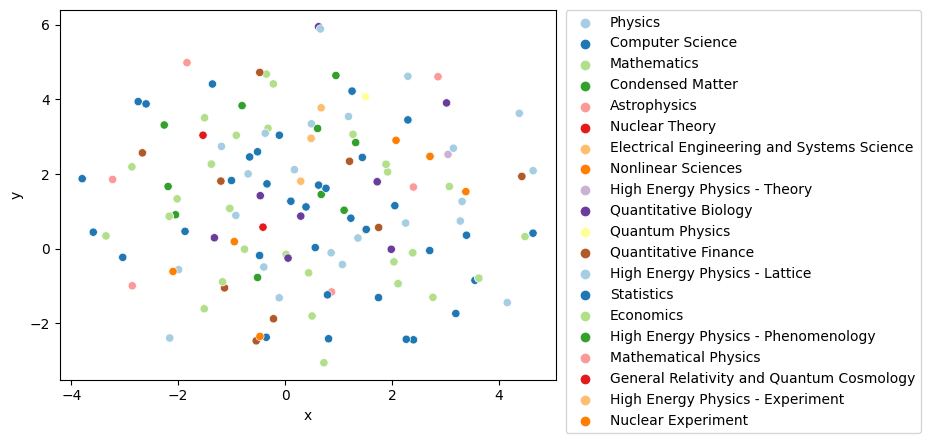

In [56]:
M =[]
for key in vocab_forward:
  M.append(embedding(key).detach().numpy())

M = np.array(M)
t = TSNE(random_state=42).fit_transform(M).transpose()

# YOU can do roughly the same thing with PCA
# pca = PCA(n_components=2)
# reduced = pca.fit_transform(M)
# t = reduced.transpose()

frame = pd.DataFrame()
frame["sub_category_id"] = list(vocab_forward.keys())
frame["x"] = t[0]
frame["y"] = t[1]
frame = frame.merge(arxiv_categories_df[["category", "sub_category_id"]], on="sub_category_id")  

def get_ahl_category(category : str):
  return ahl_category.get(category, "None")

frame["AHL Category"] = frame["category"].apply(get_ahl_category)

scatter = sns.scatterplot(frame, x="x", y="y", hue="category", palette=sns.color_palette("Paired"))
scatter.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

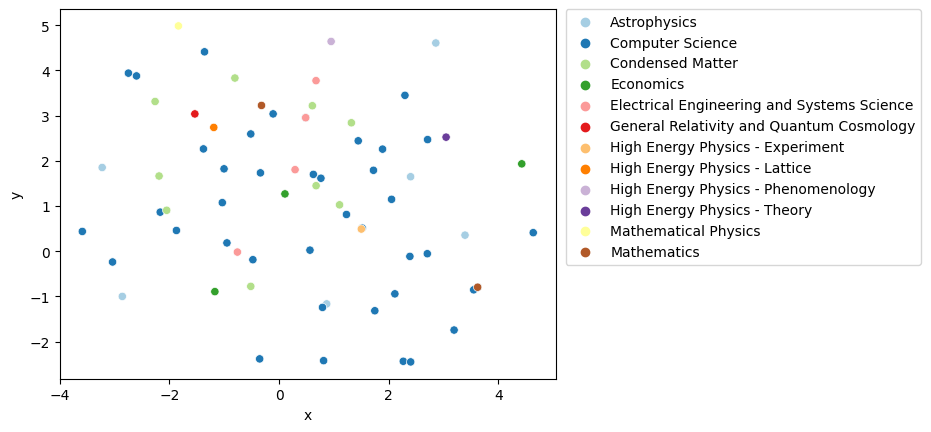

In [57]:
ordered_frame = frame.sort_values(["category"])
scatter = sns.scatterplot(ordered_frame.iloc[0:70], x="x", y="y", hue="category", palette=sns.color_palette("Paired"))
scatter.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<ipython-input-58-db8f35982c1f>:1: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  scatter = sns.scatterplot(ordered_frame.iloc[70:], x="x", y="y", hue="category", palette=sns.color_palette("Paired"))


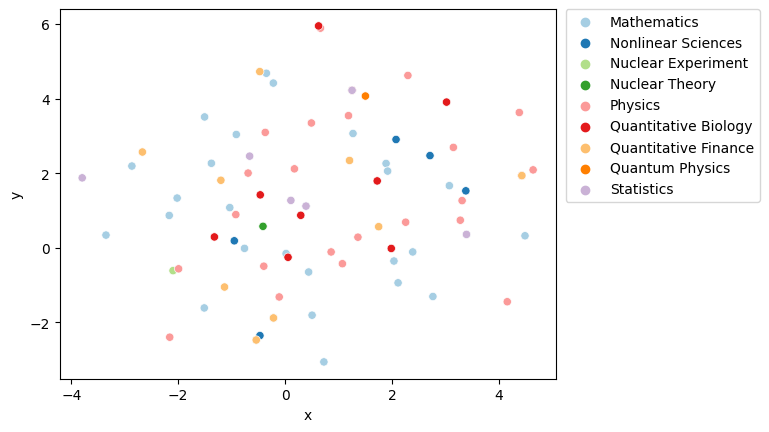

In [58]:
scatter = sns.scatterplot(ordered_frame.iloc[70:], x="x", y="y", hue="category", palette=sns.color_palette("Paired"))
scatter.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<Axes: title={'center': 'Embedding Loss by Epoch'}, xlabel='No. Epochs', ylabel='Loss (NLLoss)'>

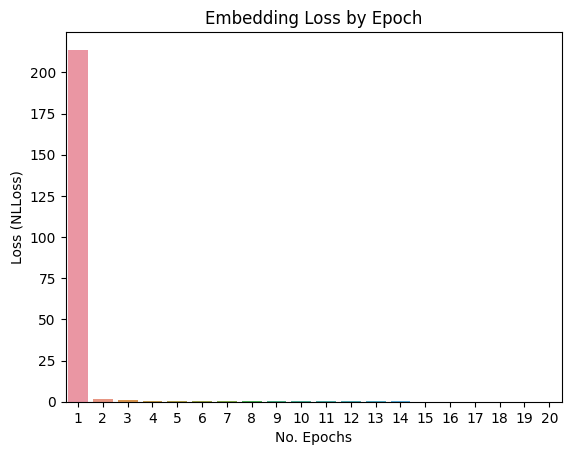

In [59]:
epoch_accuracy = sns.barplot(
  x=list(range(1, len(loss) + 1)),
  y=loss
)
sns.set(rc={"figure.figsize":(12, 7)}, font_scale=1)
epoch_accuracy.set_ylim(0, )
epoch_accuracy.set(xlabel='No. Epochs', ylabel='Loss (NLLoss)', 
        title='Embedding Loss by Epoch')
epoch_accuracy

### Word tokens

As custom embeddings weren't initially very fruitful, let's take things back a step. We can perhaps do something simpler to first connect different papers and then patents. The simpler approach may be to just look for tokens that intersect.

Here again we'll demonstrate that compute becomes a problem rather quickly. And, furthermore, that this solution does best when used with other NLP models, namely, a named entity extractor.

#### Pulling into memory

We're now going to pull a couple frames into memory, to help generate some word clouds and later perform our cross join. This will be much easier with a smaller dataset. Here we're less interested in getting a summary of our entire dataset, and more interested in the kinds of tokens we produce with each method.

In [85]:
ARXIV_IN_MEM_SAMPLE_RATE = .001

arxiv_tokens_sdf = arxiv_sdf.sample(ARXIV_IN_MEM_SAMPLE_RATE, seed=42).select(
    [
        "id", "abstract", "title", "categories_final", "subcategories_final"
    ]
)

In [86]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
arxiv_tokens_pd = pd.DataFrame.from_records(arxiv_tokens_sdf.collect(), columns=arxiv_tokens_sdf.columns)
# arxiv_tokens_sdf.collect()

#### Simple token extraction

To start off, we're simply going to add some token arrays to our Arxiv papers dataset. 

In [87]:
arxiv_tokens_pd["abstract_tokens"] = arxiv_tokens_pd["abstract"].apply(tokenize_non_stopwords)
arxiv_tokens_pd["abstract_top_tokens"] = arxiv_tokens_pd["abstract_tokens"].apply(get_top_tokens)
arxiv_tokens_pd["abstract_ne"] = arxiv_tokens_pd["abstract"].apply(get_named_entities) # most expensive
arxiv_tokens_pd["abstract_rake_tokens"] = arxiv_tokens_pd["abstract"].apply(get_rake)

In [88]:
arxiv_tokens_pd

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens
0,0705.3280,We introduce a new construction of $E_0$-sem...,Generalized CCR Flows,[],[],"[introduce, new, construction, called, general...","[type, iii, new, arising, sum, introduce, cons...","[CCR, III, Boris Tsirelson, Neumann, III]","[type, using, show, pairs, introduce, get, fin..."
1,0705.3393,"Some years ago, Cho and Vilenkin, introduced...","Vacuumless kinks systems from vacuum ones, an ...",[],[],"[years, ago, cho, vilenkin, introduced, model,...","[model, cho, vilenkin, introduced, topological...","[Cho, Vilenkin, Cho, Vilenkin, Bazeia, Liouville]","[model, introduced, words, vilenkin, vilenkin,..."
2,0705.3618,We report on a theoretical study of the elec...,Electronic Interface Reconstruction at Polar-N...,[],[],"[report, theoretical, study, electronic, inter...","[interface, reconstruction, eir, heterojunctio...","[EIR, Mott, EIR]","[reconstruction, polar, interface, heterojunct..."
3,0705.4279,For any finite unital commutative idempotent...,Amenability constants for semilattice algebras,[],[],"[finite, unital, commutative, idempotent, semi...","[show, amenability, unital, commutative, semig...",[],"[show, show, show, semilattices, compute, always]"
4,0706.0290,It is well known that Pythagorean triples ca...,Parametrization of Pythagorean triples by a si...,[],[],"[well, known, pythagorean, triples, parametriz...","[triples, polynomials, pythagorean, integer, c...","[Pythagorean, Pythagorean]","[integer, polynomials, polynomials, variables,..."
...,...,...,...,...,...,...,...,...,...
2217,quant-ph/0611045,In this work we study the properties of the ...,Entanglement properties in the Inhomogeneous T...,[],[],"[work, study, properties, atomic, entanglement...","[inhomogeneity, work, study, properties, atomi...",[Model],"[work, study, properties, present, inhomogenei..."
2218,quant-ph/9802020,Without addressing the measurement problem (...,"``Incerto tempore, incertisque loci'': Can we ...",[],[],"[without, addressing, measurement, problem, ca...","[measurement, quantum, problem, question, mech...",[],"[problem, timing, suggest, question, question,..."
2219,quant-ph/9805039,Finite precision measurement factors the Hil...,Scale decoherence in inhomogeneous potentials,[],[],"[finite, precision, measurement, factors, hilb...","[decoherence, quantum, system, fine, scale, po...","[Finite, Hilbert]","[decoherence, system, well, show, recent, part..."
2220,quant-ph/9811073,We present efficient implementations of a nu...,Tools for Quantum Algorithms,[],[],"[present, efficient, implementations, number, ...","[operations, quantum, phase, adjustments, tran...",[],"[transformations, operations, used, superposit..."


In [89]:
arxiv_tokens_pd["title_tokens"] = arxiv_tokens_pd["title"].apply(tokenize_non_stopwords)
arxiv_tokens_pd["title_top_tokens"] = arxiv_tokens_pd["title_tokens"].apply(get_top_tokens)
arxiv_tokens_pd["title_ne"] = arxiv_tokens_pd["title"].apply(get_named_entities) # most expensive
arxiv_tokens_pd["title_rake_tokens"] = arxiv_tokens_pd["title"].apply(get_rake)

In [90]:
arxiv_tokens_pd

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0705.3280,We introduce a new construction of $E_0$-sem...,Generalized CCR Flows,[],[],"[introduce, new, construction, called, general...","[type, iii, new, arising, sum, introduce, cons...","[CCR, III, Boris Tsirelson, Neumann, III]","[type, using, show, pairs, introduce, get, fin...","[generalized, ccr, flows]","[generalized, ccr, flows]",[CCR Flows],[]
1,0705.3393,"Some years ago, Cho and Vilenkin, introduced...","Vacuumless kinks systems from vacuum ones, an ...",[],[],"[years, ago, cho, vilenkin, introduced, model,...","[model, cho, vilenkin, introduced, topological...","[Cho, Vilenkin, Cho, Vilenkin, Bazeia, Liouville]","[model, introduced, words, vilenkin, vilenkin,...","[vacuumless, kinks, systems, vacuum, ones, exa...","[vacuumless, kinks, systems, vacuum, ones, exa...",[],[example]
2,0705.3618,We report on a theoretical study of the elec...,Electronic Interface Reconstruction at Polar-N...,[],[],"[report, theoretical, study, electronic, inter...","[interface, reconstruction, eir, heterojunctio...","[EIR, Mott, EIR]","[reconstruction, polar, interface, heterojunct...","[electronic, interface, reconstruction, mott, ...","[electronic, interface, reconstruction, mott, ...",[Interface Reconstruction],[polar]
3,0705.4279,For any finite unital commutative idempotent...,Amenability constants for semilattice algebras,[],[],"[finite, unital, commutative, idempotent, semi...","[show, amenability, unital, commutative, semig...",[],"[show, show, show, semilattices, compute, always]","[amenability, constants, semilattice, algebras]","[amenability, constants, semilattice, algebras]",[Amenability],[]
4,0706.0290,It is well known that Pythagorean triples ca...,Parametrization of Pythagorean triples by a si...,[],[],"[well, known, pythagorean, triples, parametriz...","[triples, polynomials, pythagorean, integer, c...","[Pythagorean, Pythagorean]","[integer, polynomials, polynomials, variables,...","[parametrization, pythagorean, triples, single...","[parametrization, pythagorean, triples, single...","[Parametrization, Pythagorean]","[polynomials, parametrization]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217,quant-ph/0611045,In this work we study the properties of the ...,Entanglement properties in the Inhomogeneous T...,[],[],"[work, study, properties, atomic, entanglement...","[inhomogeneity, work, study, properties, atomi...",[Model],"[work, study, properties, present, inhomogenei...","[entanglement, properties, inhomogeneous, model]","[entanglement, properties, inhomogeneous, model]",[],[]
2218,quant-ph/9802020,Without addressing the measurement problem (...,"``Incerto tempore, incertisque loci'': Can we ...",[],[],"[without, addressing, measurement, problem, ca...","[measurement, quantum, problem, question, mech...",[],"[problem, timing, suggest, question, question,...","[incerto, tempore, incertisque, loci, compute,...","[incerto, tempore, incertisque, loci, compute,...",[Incerto],[compute]
2219,quant-ph/9805039,Finite precision measurement factors the Hil...,Scale decoherence in inhomogeneous potentials,[],[],"[finite, precision, measurement, factors, hilb...","[decoherence, quantum, system, fine, scale, po...","[Finite, Hilbert]","[decoherence, system, well, show, recent, part...","[scale, decoherence, inhomogeneous, potentials]","[scale, decoherence, inhomogeneous, potentials]",[Scale],[]
2220,quant-ph/9811073,We present efficient implementations of a nu...,Tools for Quantum Algorithms,[],[],"[present, efficient, implementations, number, ...","[operations, quantum, phase, adjustments, tran...",[],"[transformations, operations, used, superposit...","[tools, quantum, algorithms]","[tools, quantum, algorithms]",[Quantum Algorithms],[tools]


#### Pulling frames into memory

In [91]:
arxiv_tokens_pd.to_pickle('/content/drive/MyDrive/arxiv_tokens_pd.pickle')

In [92]:
# load from pickle if you want
pd.read_pickle('/content/drive/MyDrive/arxiv_tokens_pd.pickle')

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0705.3280,We introduce a new construction of $E_0$-sem...,Generalized CCR Flows,[],[],"[introduce, new, construction, called, general...","[type, iii, new, arising, sum, introduce, cons...","[CCR, III, Boris Tsirelson, Neumann, III]","[type, using, show, pairs, introduce, get, fin...","[generalized, ccr, flows]","[generalized, ccr, flows]",[CCR Flows],[]
1,0705.3393,"Some years ago, Cho and Vilenkin, introduced...","Vacuumless kinks systems from vacuum ones, an ...",[],[],"[years, ago, cho, vilenkin, introduced, model,...","[model, cho, vilenkin, introduced, topological...","[Cho, Vilenkin, Cho, Vilenkin, Bazeia, Liouville]","[model, introduced, words, vilenkin, vilenkin,...","[vacuumless, kinks, systems, vacuum, ones, exa...","[vacuumless, kinks, systems, vacuum, ones, exa...",[],[example]
2,0705.3618,We report on a theoretical study of the elec...,Electronic Interface Reconstruction at Polar-N...,[],[],"[report, theoretical, study, electronic, inter...","[interface, reconstruction, eir, heterojunctio...","[EIR, Mott, EIR]","[reconstruction, polar, interface, heterojunct...","[electronic, interface, reconstruction, mott, ...","[electronic, interface, reconstruction, mott, ...",[Interface Reconstruction],[polar]
3,0705.4279,For any finite unital commutative idempotent...,Amenability constants for semilattice algebras,[],[],"[finite, unital, commutative, idempotent, semi...","[show, amenability, unital, commutative, semig...",[],"[show, show, show, semilattices, compute, always]","[amenability, constants, semilattice, algebras]","[amenability, constants, semilattice, algebras]",[Amenability],[]
4,0706.0290,It is well known that Pythagorean triples ca...,Parametrization of Pythagorean triples by a si...,[],[],"[well, known, pythagorean, triples, parametriz...","[triples, polynomials, pythagorean, integer, c...","[Pythagorean, Pythagorean]","[integer, polynomials, polynomials, variables,...","[parametrization, pythagorean, triples, single...","[parametrization, pythagorean, triples, single...","[Parametrization, Pythagorean]","[polynomials, parametrization]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217,quant-ph/0611045,In this work we study the properties of the ...,Entanglement properties in the Inhomogeneous T...,[],[],"[work, study, properties, atomic, entanglement...","[inhomogeneity, work, study, properties, atomi...",[Model],"[work, study, properties, present, inhomogenei...","[entanglement, properties, inhomogeneous, model]","[entanglement, properties, inhomogeneous, model]",[],[]
2218,quant-ph/9802020,Without addressing the measurement problem (...,"``Incerto tempore, incertisque loci'': Can we ...",[],[],"[without, addressing, measurement, problem, ca...","[measurement, quantum, problem, question, mech...",[],"[problem, timing, suggest, question, question,...","[incerto, tempore, incertisque, loci, compute,...","[incerto, tempore, incertisque, loci, compute,...",[Incerto],[compute]
2219,quant-ph/9805039,Finite precision measurement factors the Hil...,Scale decoherence in inhomogeneous potentials,[],[],"[finite, precision, measurement, factors, hilb...","[decoherence, quantum, system, fine, scale, po...","[Finite, Hilbert]","[decoherence, system, well, show, recent, part...","[scale, decoherence, inhomogeneous, potentials]","[scale, decoherence, inhomogeneous, potentials]",[Scale],[]
2220,quant-ph/9811073,We present efficient implementations of a nu...,Tools for Quantum Algorithms,[],[],"[present, efficient, implementations, number, ...","[operations, quantum, phase, adjustments, tran...",[],"[transformations, operations, used, superposit...","[tools, quantum, algorithms]","[tools, quantum, algorithms]",[Quantum Algorithms],[tools]


In [93]:
arxiv_tokens_pd

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0705.3280,We introduce a new construction of $E_0$-sem...,Generalized CCR Flows,[],[],"[introduce, new, construction, called, general...","[type, iii, new, arising, sum, introduce, cons...","[CCR, III, Boris Tsirelson, Neumann, III]","[type, using, show, pairs, introduce, get, fin...","[generalized, ccr, flows]","[generalized, ccr, flows]",[CCR Flows],[]
1,0705.3393,"Some years ago, Cho and Vilenkin, introduced...","Vacuumless kinks systems from vacuum ones, an ...",[],[],"[years, ago, cho, vilenkin, introduced, model,...","[model, cho, vilenkin, introduced, topological...","[Cho, Vilenkin, Cho, Vilenkin, Bazeia, Liouville]","[model, introduced, words, vilenkin, vilenkin,...","[vacuumless, kinks, systems, vacuum, ones, exa...","[vacuumless, kinks, systems, vacuum, ones, exa...",[],[example]
2,0705.3618,We report on a theoretical study of the elec...,Electronic Interface Reconstruction at Polar-N...,[],[],"[report, theoretical, study, electronic, inter...","[interface, reconstruction, eir, heterojunctio...","[EIR, Mott, EIR]","[reconstruction, polar, interface, heterojunct...","[electronic, interface, reconstruction, mott, ...","[electronic, interface, reconstruction, mott, ...",[Interface Reconstruction],[polar]
3,0705.4279,For any finite unital commutative idempotent...,Amenability constants for semilattice algebras,[],[],"[finite, unital, commutative, idempotent, semi...","[show, amenability, unital, commutative, semig...",[],"[show, show, show, semilattices, compute, always]","[amenability, constants, semilattice, algebras]","[amenability, constants, semilattice, algebras]",[Amenability],[]
4,0706.0290,It is well known that Pythagorean triples ca...,Parametrization of Pythagorean triples by a si...,[],[],"[well, known, pythagorean, triples, parametriz...","[triples, polynomials, pythagorean, integer, c...","[Pythagorean, Pythagorean]","[integer, polynomials, polynomials, variables,...","[parametrization, pythagorean, triples, single...","[parametrization, pythagorean, triples, single...","[Parametrization, Pythagorean]","[polynomials, parametrization]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217,quant-ph/0611045,In this work we study the properties of the ...,Entanglement properties in the Inhomogeneous T...,[],[],"[work, study, properties, atomic, entanglement...","[inhomogeneity, work, study, properties, atomi...",[Model],"[work, study, properties, present, inhomogenei...","[entanglement, properties, inhomogeneous, model]","[entanglement, properties, inhomogeneous, model]",[],[]
2218,quant-ph/9802020,Without addressing the measurement problem (...,"``Incerto tempore, incertisque loci'': Can we ...",[],[],"[without, addressing, measurement, problem, ca...","[measurement, quantum, problem, question, mech...",[],"[problem, timing, suggest, question, question,...","[incerto, tempore, incertisque, loci, compute,...","[incerto, tempore, incertisque, loci, compute,...",[Incerto],[compute]
2219,quant-ph/9805039,Finite precision measurement factors the Hil...,Scale decoherence in inhomogeneous potentials,[],[],"[finite, precision, measurement, factors, hilb...","[decoherence, quantum, system, fine, scale, po...","[Finite, Hilbert]","[decoherence, system, well, show, recent, part...","[scale, decoherence, inhomogeneous, potentials]","[scale, decoherence, inhomogeneous, potentials]",[Scale],[]
2220,quant-ph/9811073,We present efficient implementations of a nu...,Tools for Quantum Algorithms,[],[],"[present, efficient, implementations, number, ...","[operations, quantum, phase, adjustments, tran...",[],"[transformations, operations, used, superposit...","[tools, quantum, algorithms]","[tools, quantum, algorithms]",[Quantum Algorithms],[tools]


#### Word Clouds

In [94]:
# drawing function of wordcloud
# TODO : show wc horizontally
def draw_wc(token_counts, title, ax):
  wordcloud = WordCloud(width = 640, height = 640,
                background_color ='white',
                min_font_size = 8).fit_words(token_counts)
 
  # plot the WordCloud image                      
  # ax.figure(figsize = (4, 4), facecolor = None)
  ax.imshow(wordcloud)
  ax.axis("off")
  ax.set_title(title)

def plot_top_10_tokens(token_counts, title, ax):
  top_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:20]
  sns.barplot(x=[x[0] for x in top_tokens], y=[x[1] for x in top_tokens], ax=ax)
  ax.set_title(title)
  ax.set_ylabel('Counts')
  ax.tick_params(axis='x', rotation=45)
  plt.subplots_adjust(hspace = 0.7)

In [95]:
abstract_tokens_total = [token for tokens in list(arxiv_tokens_pd["abstract_tokens"]) for token in tokens]
abstract_token_counts = Counter(abstract_tokens_total)

abstract_nes_total = [token for tokens in list(arxiv_tokens_pd["abstract_ne"]) for token in tokens]
abstract_nes_counts = Counter(abstract_nes_total)

abstract_rakes_total = [token for tokens in list(arxiv_tokens_pd["abstract_rake_tokens"]) for token in tokens]
abstract_rakes_counts = Counter(abstract_rakes_total)

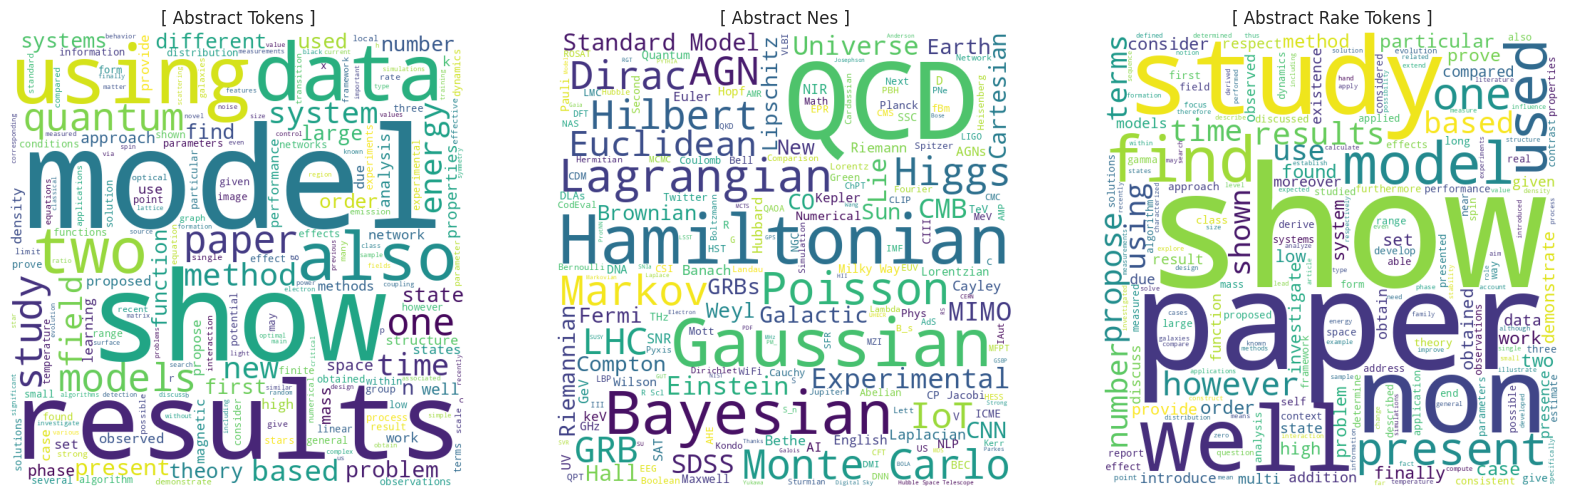

In [96]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

draw_wc(abstract_token_counts, "[ Abstract Tokens ]", axs[0])
draw_wc(abstract_nes_counts, "[ Abstract Nes ]", axs[1])
draw_wc(abstract_rakes_counts, "[ Abstract Rake Tokens ]", axs[2])

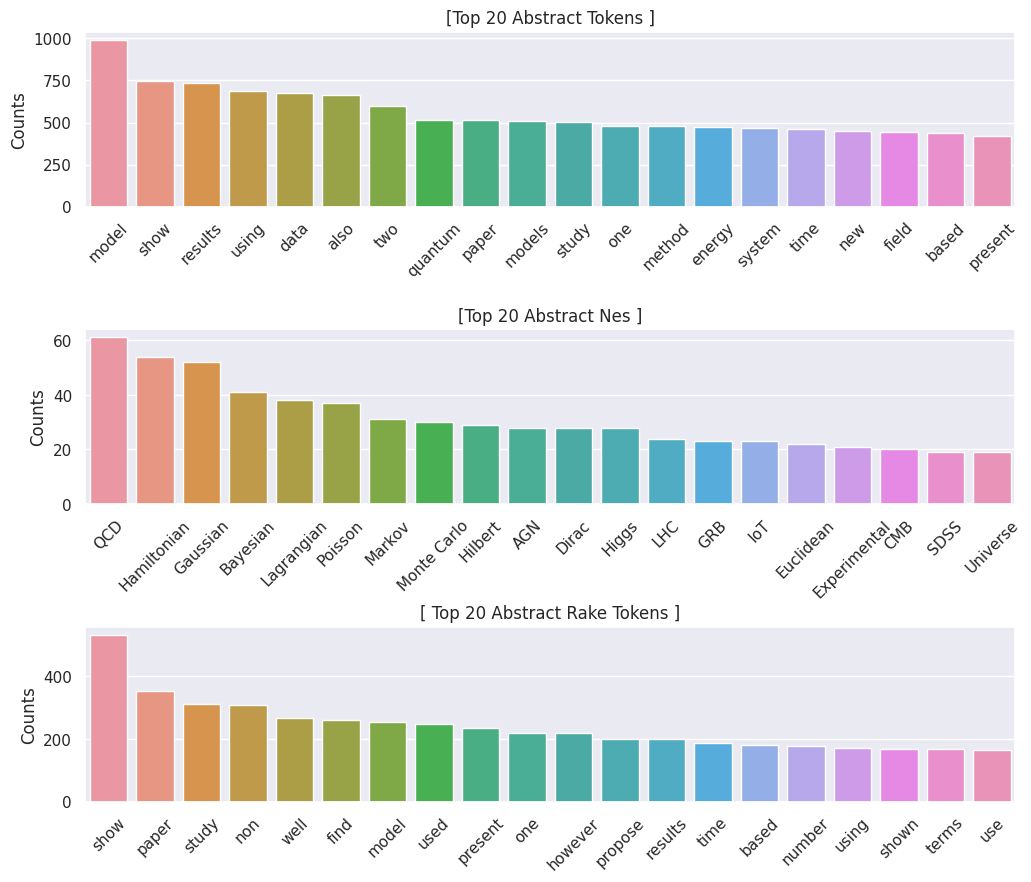

In [97]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

plot_top_10_tokens(abstract_token_counts, "[Top 20 Abstract Tokens ]", axs[0])
plot_top_10_tokens(abstract_nes_counts, "[Top 20 Abstract Nes ]", axs[1])
plot_top_10_tokens(abstract_rakes_counts, "[ Top 20 Abstract Rake Tokens ]", axs[2])

In [98]:
title_tokens_total = [token for tokens in list(arxiv_tokens_pd["title_tokens"]) for token in tokens]
title_token_counts = Counter(title_tokens_total)

title_nes_total = [token for tokens in list(arxiv_tokens_pd["title_ne"]) for token in tokens]
title_nes_counts = Counter(title_nes_total)

title_rakes_total = [token for tokens in list(arxiv_tokens_pd["title_rake_tokens"]) for token in tokens]
title_rakes_counts = Counter(title_rakes_total)

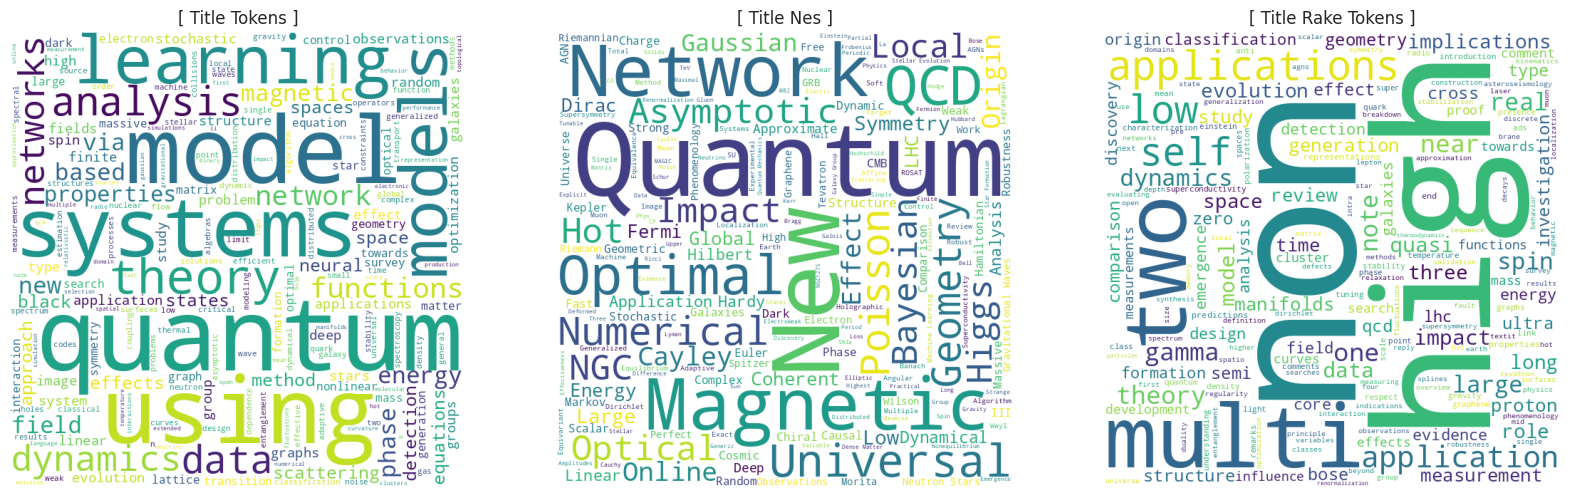

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

draw_wc(title_token_counts, "[ Title Tokens ]", axs[0])
draw_wc(title_nes_counts, "[ Title Nes ]", axs[1])
draw_wc(title_rakes_counts, "[ Title Rake Tokens ]", axs[2])

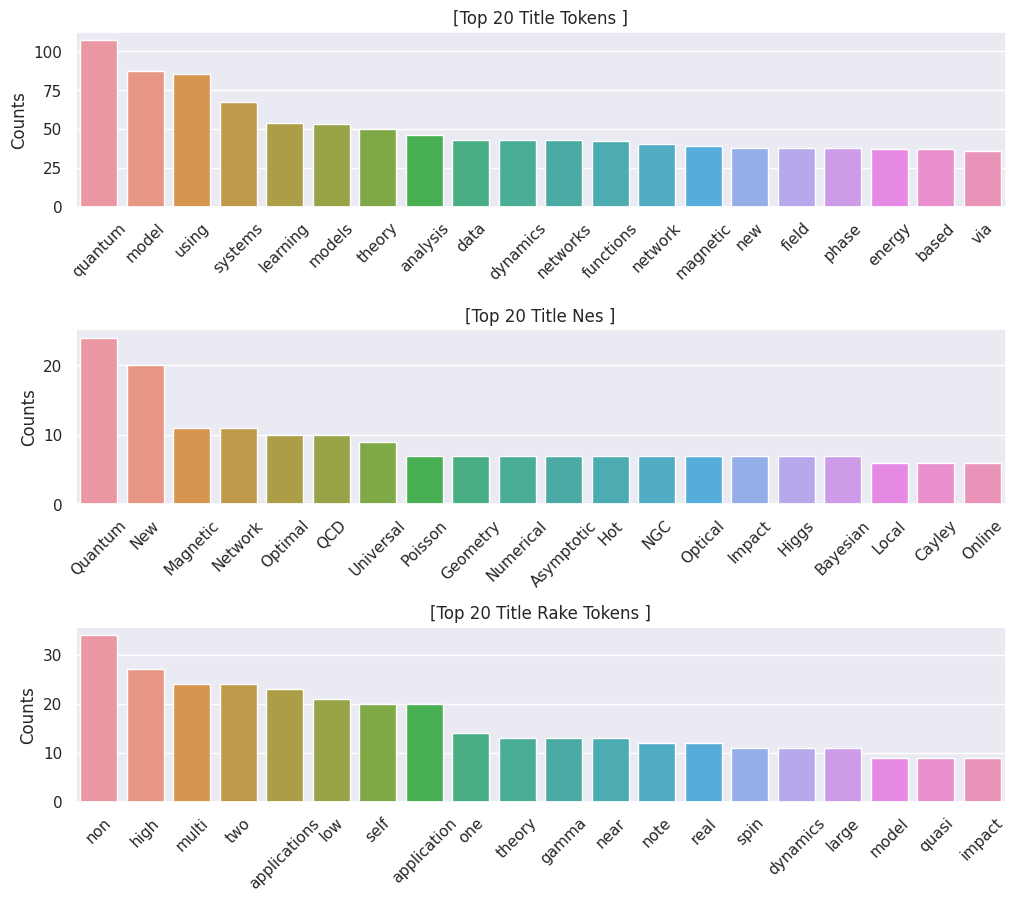

In [100]:

fig, axs = plt.subplots(3, 1, figsize=(12, 10))

plot_top_10_tokens(title_token_counts, "[Top 20 Title Tokens ]", axs[0])
plot_top_10_tokens(title_nes_counts, "[Top 20 Title Nes ]", axs[1])
plot_top_10_tokens(title_rakes_counts, "[Top 20 Title Rake Tokens ]", axs[2])

#### Token adjacency


We can now begin to join papers with one another via their shared tokens. 

In [101]:
def intersection(left, right):
    return list(set(left) & set(right))

def build_graph_df(df1 : pd.DataFrame, df2 : pd.DataFrame, token : str):
  # Merge the two DataFrames  
  product = pd.merge(df1, df2, how='cross')
  # Find the intersection of the 'title_tokens_x' and 'title_tokens_y' columns
  product[f'shared_{token}'] = product.apply(lambda row: intersection(row[f'{token}_x'], row[f'{token}_y']), axis=1)

  # Print the result
  return product[product[f"shared_{token}"].map(len) > 0]

### Benchmarking against categories

Now we're going to check how well first order BFS matching lines up with categories. All accuracy scores are going to be low. For now, we're going to mainly focus on specifity under the following assumptions:

(i)
$$
||papers\ in\ categories|| >> ||recommended\ papers||
$$

(ii) High specificity and low accuracy can be used to argue that a small number of papers in the category are being recommended, and large proportion of papers outside the category are not being recommended.

The efforts below are heavily affected by class imbalance. Proportions of negative and positive examples for a given category are not nearly equivalent.

We take a more comprehensive and manual approach to this in the models sections. Wherein we also discuss how limited this approach is.


In [102]:
categories_intersect_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "categories_final")
cross_size = arxiv_tokens_pd.shape[0] ** 2
# this is the intersection of categories

#### Title tokens

We'll check title tokens first.

In [103]:
title_tokens_intersect_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "title_tokens")

In [104]:
titles_categories_pd = title_tokens_intersect_pd[["id_x", "id_y"]].merge(
    categories_intersect_pd[["id_x", "id_y"]],
    on=["id_x", "id_y"],
    indicator=True,
    how="outer"
)
titles_categories_pd.shape[0], titles_categories_pd[
    titles_categories_pd["_merge"] == "both"
].shape[0], titles_categories_pd[
    titles_categories_pd["_merge"] == "left_only"
].shape[0], titles_categories_pd[
    titles_categories_pd["_merge"] == "right_only"
].shape[0]

(4937284, 141587, 0, 4795697)

Now let's compute our confusion matrix as if the categories intersection were our labels.

In [105]:
tp = titles_categories_pd[
    titles_categories_pd["_merge"] == "both"
].shape[0]
fp = titles_categories_pd[
    titles_categories_pd["_merge"] == "left_only"
].shape[0]
fn = titles_categories_pd[
    titles_categories_pd["_merge"] == "right_only"
].shape[0]
tn = cross_size - tp - fp - fn

(tp, fp, fn, tn), (tp/(tp + fn + 1)), (tn/(tn + fp + 1))

((141587, 0, 4795697, 0), 0.028677096825482022, 0.0)

```
# representative example
((141068, 0, 4672568, 0), 0.029305907362769563, 0.0)
```

Our performance on this model is terrible. Though the the low true positivity rate with non-existent false-negatives could be good, we are not picking up on any true negatives.

#### Abstract named entities

In [106]:
abstract_ne_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "abstract_ne")

In [107]:
abstract_ne_categories_pd = abstract_ne_pd[["id_x", "id_y"]].merge(
    categories_intersect_pd[["id_x", "id_y"]],
    on=["id_x", "id_y"],
    indicator=True,
    how="outer"
)

abstract_ne_categories_pd.shape[0], abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "both"
].shape[0], abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "left_only"
].shape[0], abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "right_only"
].shape[0]

(4937284, 20417, 0, 4916867)

In [108]:
tp = abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "both"
].shape[0]
fp = abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "left_only"
].shape[0]
fn = abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "right_only"
].shape[0]
tn = cross_size - tp - fp - fn

(tp, fp, fn, tn), (tp/(tp + fn + 1)), (tn/(tn + fp + 1))

((20417, 0, 4916867, 0), 0.004135268674990405, 0.0)

Okay, cool! Joined on named entities in the abstracts is an even more specifc model. Before we move to subcategories, let's check out a version that might perform so well. Let's do top tokens from the abstract.

#### Abstract rake

In [109]:
abstract_top_tokens_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "abstract_top_tokens")

In [110]:
abstract_top_categories_pd = abstract_top_tokens_pd[["id_x", "id_y"]].merge(
    categories_intersect_pd[["id_x", "id_y"]],
    on=["id_x", "id_y"],
    indicator=True,
    how="outer"
)

abstract_top_categories_pd.shape[0], abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "both"
].shape[0], abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "left_only"
].shape[0], abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "right_only"
].shape[0]

(4937284, 437828, 0, 4499456)

In [111]:
tp = abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "both"
].shape[0]
fp = abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "left_only"
].shape[0]
fn = abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "right_only"
].shape[0]
tn = cross_size - tp - fp - fn

(tp, fp, fn, tn), (tp/(tp + fn + 1)), (tn/(tn + fp + 1))

((437828, 0, 4499456, 0), 0.08867788673329573, 0.0)

That works surprisingly well! We traded true negativity for false positivy--losing specificy--as we would expect. However, overall, we're still tracking pretty well. Let's check out how this works against subcategories.

### Benchmarking against subcategories

Okay, so here is where things get a little more interesting. We'll want to watch our true positivity, it should climb a little, but we still want it to be low. If we can have high-specifity with a little bump in the true positivity, then we're on the right track. 

In [112]:
sub_categories_intersect_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "subcategories_final")
cross_size = arxiv_tokens_pd.shape[0] ** 2

#### Abstract named entities

In [113]:
abstract_ne_sub_categories_pd = abstract_ne_pd[["id_x", "id_y"]].merge(
    sub_categories_intersect_pd[["id_x", "id_y"]],
    on=["id_x", "id_y"],
    indicator=True,
    how="outer"
)

abstract_ne_sub_categories_pd.shape[0], abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "both"
].shape[0], abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "left_only"
].shape[0], abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "right_only"
].shape[0]

(4937284, 20417, 0, 4916867)

In [114]:
tp = abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "both"
].shape[0]
fp = abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "left_only"
].shape[0]
fn = abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "right_only"
].shape[0]
tn = cross_size - tp - fp - fn

(tp, fp, fn, tn), (tp/(tp + fn + 1)), (tn/(tn + fp + 1))

((20417, 0, 4916867, 0), 0.004135268674990405, 0.0)

Awesome! This maintains close to the same very high specificity rate and we don't see much of a gain in true positivity, which likely indicates we're not just recommending anything in the subcategory.

We're going to move on from these exercises and start looking at some models.

## Models

### Review methodology

We don't have labels, but to do a moderately rigorous review, we decided to produce some ourselves. To accomplish this we examined a sample of the Cartesian product of all recommendations. 

We determined our sample size, as follows.

> **Population**
> $$(||patents|| * ||papers||) = (10^{6})^{2} = 10^{12} $$

> **Proportion**
> $$positives < \frac{1}{||subcategories||} = \frac{1}{134} \approx .01 $$

> **Sample**
> $$\alpha = 0.05$$ and $$MOE = 0.04$$ we obtain a sample size of $$24$$.


We classified each possible recommendation as positive or negative, then insepected the recommendation prompts that could have produced said recommendation, i.e., a query for the left id. The following summarizes our confusion classification.


> **True positive:** included in the recommendation, positively classified in the Cartesian product.

> **False positive:** included in the recommendation, negatively classified in the Cartesian product.

> **True negative:** not included in the recommendation, negatively classified in the Cartesian product.

> **False negative:** not included in the recommedation, positively classified in the Cartesian product.



On the full versions of the models included below, we produced the following.

In [143]:
recommendation_results = pd.DataFrame.from_records([
    
    # tokens to tokens with named entities
    {
        "model_name" : "TokensToTokens_title_ne",
        "tp" : 2,
        "fn" : 1,
        "fp" : 7,
        "tn" : 14
    },
    {
        "model_name" : "TokensToTokens_abstract_ne",
        "tp" : 4,
        "fn" : 2,
        "fp" : 7,
        "tn" : 11
    },

    # sbert avg
    {
        "model_name" : "TokensToTokens_abstract_ne",
        "tp" : 9,
        "fn" : 0,
        "fp" : 6,
        "tn" : 9
    },

    # custom embedding
    {
        "model_name" : "AhlEmbeddingAvg_10_epochs",
        "tp" : 7,
        "fn" : 5,
        "fp" : 4,
        "tn" : 8
    },
    {
        "model_name" : "AhlEmbeddingAvg_25_epochs",
        "tp" : 11,
        "fn" : 2,
        "fp" : 6,
        "tn" : 7
    },

    # sbert cnn
    {
        "model_name" : "SbertCnn_12_epochs",
        "tp" : 2,
        "fn" : 5,
        "fp" : 12,
        "tn" : 5
    }

])

recommendation_results

,model_name,tp,fn,fp,tn
0,TokensToTokens_title_ne,2,1,7,14
1,TokensToTokens_abstract_ne,4,2,7,11
2,TokensToTokens_abstract_ne,9,0,6,9
3,AhlEmbeddingAvg_10_epochs,7,5,4,8
4,AhlEmbeddingAvg_25_epochs,11,2,6,7
5,SbertCnn_12_epochs,2,5,12,5


##### True positives by model

[Text(0.5, 0, 'Model Name'),
 Text(0, 0.5, 'True Positives out of 24 Samples'),
 Text(0.5, 1.0, 'True Positives for AHL Models')]

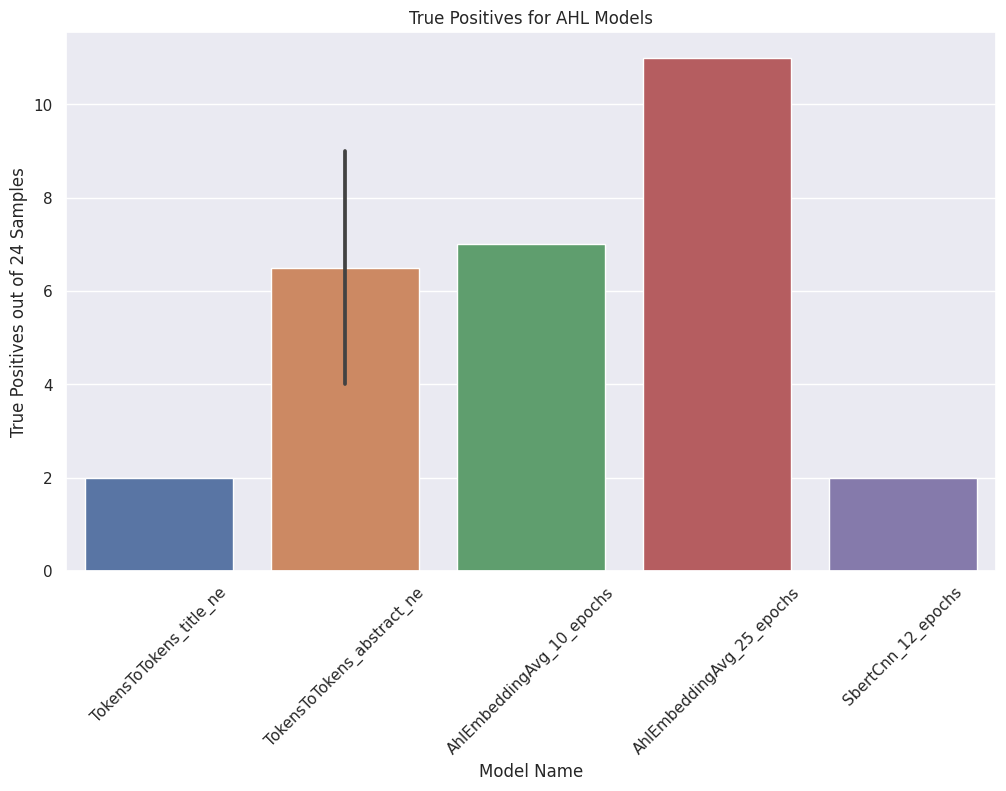

In [237]:
tp_plot = sns.barplot(recommendation_results, x="model_name", y="tp")
for item in tp_plot.get_xticklabels():
    item.set_rotation(45)
sns.set(rc={"figure.figsize":(12, 7)}, font_scale=1)
tp_plot.set_ylim(0, )
tp_plot.set(xlabel='Model Name', ylabel='True Positives out of 24 Samples', 
        title='True Positives for AHL Models')

##### False negatives by model

[Text(0.5, 0, 'Model Name'),
 Text(0, 0.5, 'False Negatives out of 24 Samples'),
 Text(0.5, 1.0, 'False Negatives for AHL Models')]

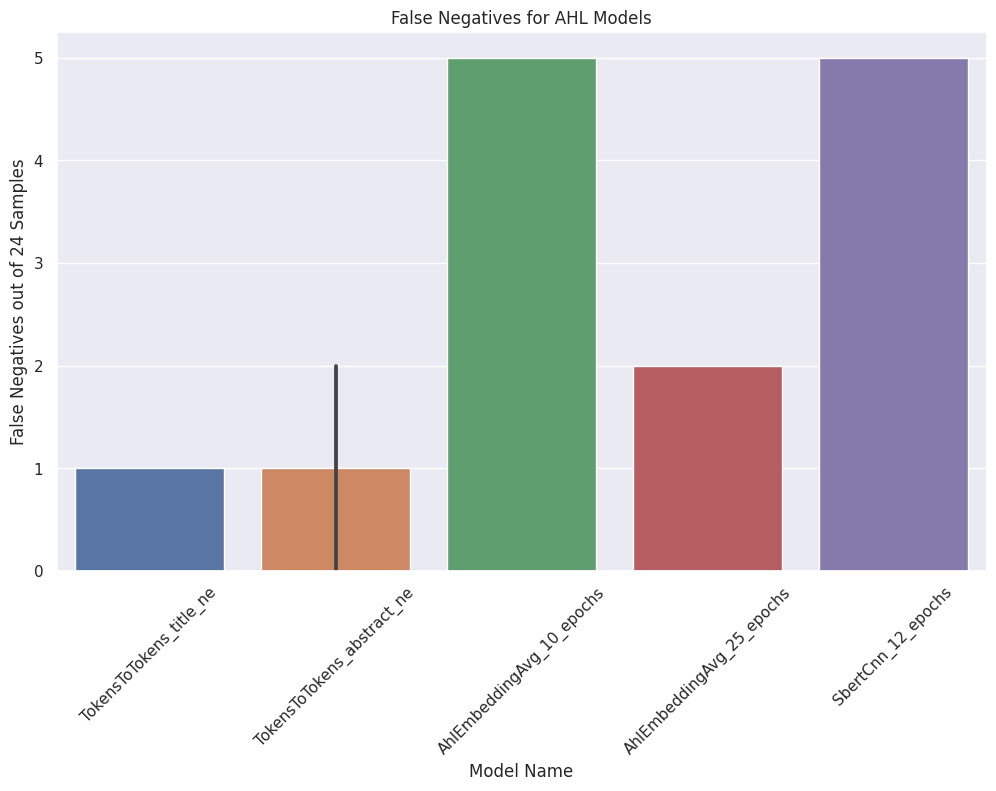

In [238]:
fn_plot = sns.barplot(recommendation_results, x="model_name", y="fn")
for item in fn_plot.get_xticklabels():
    item.set_rotation(45)
sns.set(rc={"figure.figsize":(12, 7)}, font_scale=1)
fn_plot.set_ylim(0, )
fn_plot.set(xlabel='Model Name', ylabel='False Negatives out of 24 Samples', 
        title='False Negatives for AHL Models')

#### False positives by model

[Text(0.5, 0, 'Model Name'),
 Text(0, 0.5, 'False Positives out of 24 Samples'),
 Text(0.5, 1.0, 'False Positives for AHL Models')]

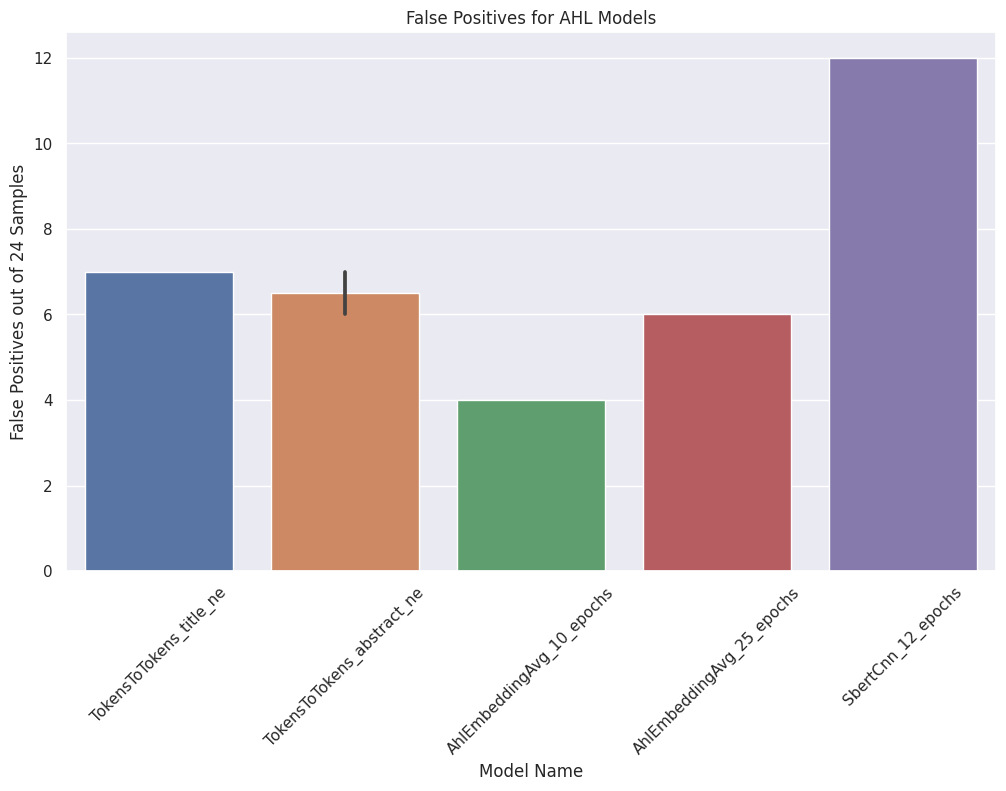

In [239]:
fp_plot = sns.barplot(recommendation_results, x="model_name", y="fp")
for item in fp_plot.get_xticklabels():
    item.set_rotation(45)
sns.set(rc={"figure.figsize":(12, 7)}, font_scale=1)
fp_plot.set_ylim(0, )
fp_plot.set(xlabel='Model Name', ylabel='False Positives out of 24 Samples', 
        title='False Positives for AHL Models')

##### True negatives

[Text(0.5, 0, 'Model Name'),
 Text(0, 0.5, 'True Negatives out of 24 Samples'),
 Text(0.5, 1.0, 'True Negatives for AHL Models')]

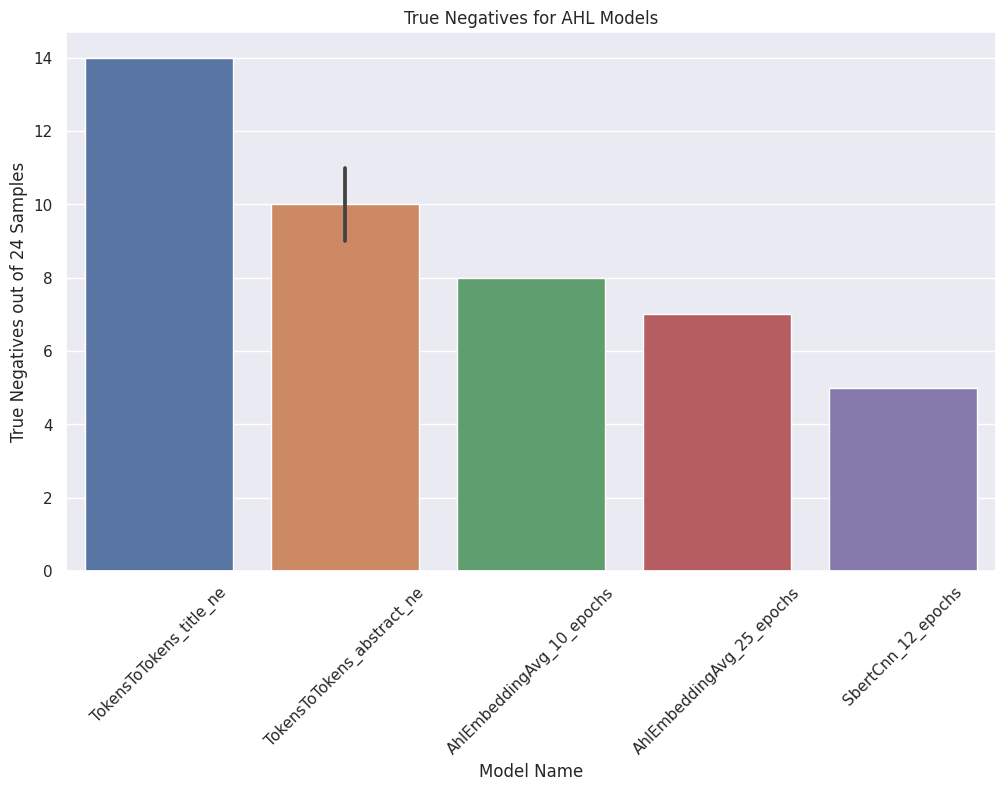

In [241]:
tn_plot = sns.barplot(recommendation_results, x="model_name", y="tn")
for item in tn_plot.get_xticklabels():
    item.set_rotation(45)
sns.set(rc={"figure.figsize":(12, 7)}, font_scale=1)
tn_plot.set_ylim(0, )
tn_plot.set(xlabel='Model Name', ylabel='True Negatives out of 24 Samples', 
        title='True Negatives for AHL Models')

So, there's how these models stack up. Let's get into it!

### Patent data

Before we get started, let's give the patent data a similar treament to paper data. 

We'll only be keeping the abstract, the application number, and the named entity tokenization for the patents though.

In [115]:
ARXIV_IN_MEM_SAMPLE_RATE = .001

patent_tokens_sdf = train_patents_sdf.sample(ARXIV_IN_MEM_SAMPLE_RATE, seed=42).select(
    [
        "application_number", "abstract"
    ]
)

In [116]:
patent_tokens_pd = pd.DataFrame.from_records(patent_tokens_sdf.collect(), columns=patent_tokens_sdf.columns)

In [117]:
patent_tokens_pd["abstract_tokens"] = patent_tokens_pd["abstract"].apply(tokenize_non_stopwords) # most expensive
patent_tokens_pd = patent_tokens_pd.dropna()

### Protocol

The models below adhere to the following protocol for predicting patents from papers and vice versa. This protocol is a modified version of the protocol used to support the `pap2pat` backend. Expensive routines have been trimmed, or left unimplemented.

In [118]:
class Pap2Pat(Protocol):

  def train(self, *args, **kwargs):
    pass

  def charts(self, *args, **kwargs):
    pass

  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    pass

  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    pass

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    pass

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    pass


In [181]:
example_paper = arxiv_tokens_pd.head(1)
example_paper_id = example_paper.iloc[0]["id"]
example_paper

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0705.3280,We introduce a new construction of $E_0$-sem...,Generalized CCR Flows,[],[],"[introduce, new, construction, called, general...","[type, iii, new, arising, sum, introduce, cons...","[CCR, III, Boris Tsirelson, Neumann, III]","[type, using, show, pairs, introduce, get, fin...","[generalized, ccr, flows]","[generalized, ccr, flows]",[CCR Flows],[]


### `TokensToTokens`

In the `TokensToTokens` model, we take the same first-order BFS approach used for the papers above, and apply it to join the papers and patents, and vice versa.

In [119]:
class TokensToTokens(Pap2Pat):

  def __init__(self):

    # clean up arxiv_tokens
    self.arxiv_tokens_pd = arxiv_tokens_pd[
        ["id", "abstract_tokens"]
    ]
    self.arxiv_tokens_pd["which"] = "paper"

    # clean up papten_tokens
    self.patent_tokens_pd = patent_tokens_pd[
        ["application_number", "abstract_tokens"]
    ]
    self.patent_tokens_pd = self.patent_tokens_pd.rename({ 
        "application_number" : "id"
    })
    self.patent_tokens_pd["which"] = "patent"

  def train(self):

    combined = pd.concat([
        self.arxiv_tokens_pd,
        self.patent_tokens_pd
    ])

    self.home_table = build_graph_df(
        combined,
        combined,
        "abstract_tokens"
    )

  def charts(self):
    pass

  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    return self.home_table[
        (self.home_table["id_x"] == paper_id)
        & (self.home_table["which_y"] == "patent")
    ]


  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    return self.home_table[
        (self.home_table["id_x"] == paper_id)
        & (self.home_table["which_y"] == "paper")
    ]

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    return self.home_table[
        (self.home_table["id_x"] == patent_id)
        & (self.home_table["which_y"] == "paper")
    ]

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    return self.home_table[
        (self.home_table["id_x"] == patent_id)
        & (self.home_table["which_y"] == "patent")
    ]


In [120]:
tokens_to_tokens = TokensToTokens()


<ipython-input-119-7c8893255fbb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.arxiv_tokens_pd["which"] = "paper"


In [121]:
tokens_to_tokens.train()

Example of paper to papers recommendation.

In [130]:
tokens_to_tokens.pap2pap(paper_id=example_paper_id)

CALLING:  0705.3280


,id_x,abstract_tokens_x,which_x,application_number_x,id_y,abstract_tokens_y,which_y,application_number_y,shared_abstract_tokens
0,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,"[necessary, algebras, given, von, many, introd..."
1,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,0705.3393,"[years, ago, cho, vilenkin, introduced, model,...",paper,NaN,"[called, introduced, finally, new]"
2,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,0705.3618,"[report, theoretical, study, electronic, inter...",paper,NaN,"[system, systems]"
3,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,0705.4279,"[finite, unital, commutative, idempotent, semi...",paper,NaN,"[algebras, finite, show]"
4,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,0706.0290,"[well, known, pythagorean, triples, parametriz...",paper,NaN,"[two, sufficient, show]"
...,...,...,...,...,...,...,...,...,...
2214,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,quant-ph/0507004,"[introduce, novel, semiclassical, approach, li...",paper,NaN,"[arising, system, introduce, new]"
2215,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,quant-ph/0605245,"[analyze, scheme, manipulate, quantum, states,...",paper,NaN,"[using, show]"
2216,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,quant-ph/0609016,"[semiclassical, approximations, tunneling, pro...",paper,NaN,"[finite, show]"
2219,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,quant-ph/9805039,"[finite, precision, measurement, factors, hilb...",paper,NaN,"[system, finite, considering, show]"


Example of paper to patents recommendation.

In [131]:
tokens_to_tokens.pap2pat(paper_id=example_paper_id)

,id_x,abstract_tokens_x,which_x,application_number_x,id_y,abstract_tokens_y,which_y,application_number_y,shared_abstract_tokens
2223,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,NaN,"[imaging, system, exciting, measuring, fluores...",patent,US-70484210-A,[system]
2224,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,NaN,"[circuit, system, provided, capable, improving...",patent,US-25183805-A,"[two, system]"
2225,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,NaN,"[serial, input, output, device, includes, cmos...",patent,US-63398984-A,"[associated, type]"
2226,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,NaN,"[accordance, present, invention, water, develo...",patent,US-62150896-A,"[sufficient, many]"
2228,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,NaN,"[method, determining, locations, loads, vehicl...",patent,US-201213371691-A,"[using, type, new]"
...,...,...,...,...,...,...,...,...,...
2677,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,NaN,"[two, piece, induction, seal, use, creating, c...",patent,US-93888107-A,[two]
2678,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,NaN,"[underground, line, locating, receiver, disclo...",patent,US-18934202-A,[condition]
2679,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,NaN,"[one, aspect, present, invention, relates, pro...",patent,US-88225886-A,"[sufficient, systems]"
2682,0705.3280,"[introduce, new, construction, called, general...",paper,NaN,NaN,"[disclosed, herewith, packet, transfer, appara...",patent,US-7376608-A,[flows]


The plots for this model are similar to those provided in the exploration. To save on runtime, we will not be reproducing them here.

Now that we have our recommender, we can see that the results from joining on abstract tokens aren't all that compelling. Let's try using an embedding that someone else wrote for us.

### `SbertAvg`

In the `SbertAvg` model, we take an average of Sbert sentences embeddings and compute the cosine similarity between any two of them to produce a similarity by which be rank matching candidates.

In [187]:
class SbertAvg(Pap2Pat):

  sbert = SentenceTransformer('all-MiniLM-L6-v2')
  size : int = 10

  def __init__(self, *, size : int):
    self.size = size

    self.arxiv_pd = arxiv_tokens_pd[["id", "abstract"]].astype({
        "id" : "string",
        "abstract" : "string"
    }).head(100)
    self.arxiv_pd.rename(columns={
        "id" : "id",
        "abstract" : "abstract"
    })

    self.patents_pd = patent_tokens_pd[[
        "application_number",
        "abstract"
    ]].astype({
        "application_number" : "string",
        "abstract" : "string"
    }).head(100)
    self.patents_pd = self.patents_pd.rename(columns={
        "application_number" : "id",
        "abstract" : "abstract"    
    })

    self.arxiv_pd["which"] = "paper"
    self.patents_pd["which"] = "patent" 

    self.recommender_table = pd.concat([
        self.arxiv_pd,
        self.patents_pd
     ])

  def encode_text(self, text : str):

    sentences = tokenize_sentences(text)
    encoding = self.sbert.encode(sentences)
    return torch.from_numpy(np.average(encoding, axis=0))

  def train(self, *args, **kwargs):
    # just emebd all of the abstracts
    self.recommender_table["aemb"] = self.recommender_table["abstract"].apply(self.encode_text)

  
  def charts(self, *args, **kwargs):
    pass


  def compute_top_n_cosine(
      self, 
      *,
      df : pd.DataFrame, 
      id : str, 
      n : int,
      which : str
  ):

    embedding = df[df["id"]==id]["aemb"].iloc[0]
    target = df[
        (df["id"] != id)
        & (df["which"] == which)
    ]

    sim = nn.CosineSimilarity()
    values, indices = sim(
      embedding, 
      torch.stack(target["aemb"].tolist())
    ).sort(descending=True)
    top_indices = indices[0:n]

    return target.iloc[top_indices]


  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=paper_id, 
        n=self.size, 
        which="patent"
    )

  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=paper_id, 
        n=self.size, 
        which="paper"
    )

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=patent_id, 
        n=self.size, 
        which="paper"
    )

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=patent_id, 
        n=self.size, 
        which="patent"
    )



In [188]:
sbert_avg = SbertAvg(size=10)

In [189]:
sbert_avg.train()

In [206]:
sbert_avg.recommender_table

,id,abstract,which,aemb
0,0705.3280,We introduce a new construction of $E_0$-sem...,paper,"[tensor(-0.0604), tensor(0.0184), tensor(-0.01..."
1,0705.3393,"Some years ago, Cho and Vilenkin, introduced...",paper,"[tensor(-0.0769), tensor(-0.0592), tensor(0.00..."
2,0705.3618,We report on a theoretical study of the elec...,paper,"[tensor(-0.0595), tensor(0.0078), tensor(-0.01..."
3,0705.4279,For any finite unital commutative idempotent...,paper,"[tensor(-0.0274), tensor(0.0709), tensor(0.011..."
4,0706.0290,It is well known that Pythagorean triples ca...,paper,"[tensor(-0.0465), tensor(0.0525), tensor(-0.10..."
...,...,...,...,...
95,US-20350398-A,a technique of utilizing a sulfuric acid / per...,patent,"[tensor(-0.0103), tensor(0.0175), tensor(-0.01..."
96,US-64241584-A,a material with high thermal conductivity for ...,patent,"[tensor(-0.0184), tensor(-0.0102), tensor(-0.0..."
97,US-45586683-A,compounds acting as antagonists of the antidiu...,patent,"[tensor(-0.0400), tensor(0.0085), tensor(-0.07..."
98,US-51821600-A,"a fast acting , low insertion loss switch for ...",patent,"[tensor(0.0085), tensor(-0.0222), tensor(-0.00..."


Sample paper to paper recommendation.

In [190]:
example_paper

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0705.3280,We introduce a new construction of $E_0$-sem...,Generalized CCR Flows,[],[],"[introduce, new, construction, called, general...","[type, iii, new, arising, sum, introduce, cons...","[CCR, III, Boris Tsirelson, Neumann, III]","[type, using, show, pairs, introduce, get, fin...","[generalized, ccr, flows]","[generalized, ccr, flows]",[CCR Flows],[]


In [191]:
sbert_avg.pap2pap(paper_id=example_paper_id)

,id,abstract,which,aemb
3,0705.4279,For any finite unital commutative idempotent...,paper,"[tensor(-0.0274), tensor(0.0709), tensor(0.011..."
21,0708.1695,"For L a finite lattice, let C(L) denote the ...",paper,"[tensor(-0.0095), tensor(0.0361), tensor(0.002..."
97,0812.0715,Joinings of C*-dynamical systems are defined...,paper,"[tensor(-0.0732), tensor(-0.0022), tensor(-0.0..."
98,0812.1408,In this paper we show that the reducibility ...,paper,"[tensor(-0.0198), tensor(0.0154), tensor(0.029..."
11,0707.0144,Let G be a connected reductive group (over $...,paper,"[tensor(-0.0557), tensor(0.0119), tensor(0.037..."
56,0803.3121,We study a product rule and a difference ope...,paper,"[tensor(-0.0422), tensor(0.0045), tensor(0.046..."
30,0711.2195,We construct families of Calabi-Yau manifold...,paper,"[tensor(-0.0844), tensor(0.0036), tensor(-0.01..."
36,0801.0351,We introduce a machine free mathematical fra...,paper,"[tensor(-0.0249), tensor(-0.0343), tensor(0.03..."
94,0811.3182,We analyze the construction of a sequence sp...,paper,"[tensor(-0.1121), tensor(-0.0543), tensor(-0.0..."
68,0806.0193,We discuss the boundedness of Berezin-Toepli...,paper,"[tensor(-0.0986), tensor(0.0103), tensor(0.001..."


Sample papeer to patent recommendation.

In [192]:
example_paper

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0705.3280,We introduce a new construction of $E_0$-sem...,Generalized CCR Flows,[],[],"[introduce, new, construction, called, general...","[type, iii, new, arising, sum, introduce, cons...","[CCR, III, Boris Tsirelson, Neumann, III]","[type, using, show, pairs, introduce, get, fin...","[generalized, ccr, flows]","[generalized, ccr, flows]",[CCR Flows],[]


In [193]:
sbert_avg.pap2pat(paper_id=example_paper_id)

,id,abstract,which,aemb
92,US-35899389-A,the invention relates to a class of copolymers...,patent,"[tensor(-0.0940), tensor(-0.1283), tensor(0.04..."
90,US-12985687-A,a sintered article of silicon carbide containi...,patent,"[tensor(0.0182), tensor(0.0149), tensor(-0.046..."
75,US-90822610-A,a self - contained mixing and dispensing conta...,patent,"[tensor(-0.0228), tensor(-0.0239), tensor(-0.0..."
46,US-81197401-A,embodiments of the present invention are direc...,patent,"[tensor(-0.1146), tensor(0.0487), tensor(-0.06..."
33,US-201414483380-A,a method of use of a dusting tool for cleaning...,patent,"[tensor(-0.0584), tensor(0.0068), tensor(0.067..."
60,US-11251405-A,a kernel cracking assembly comprises two frame...,patent,"[tensor(-0.0799), tensor(-0.0565), tensor(-0.0..."
62,US-81715897-A,a surveillance camera assembly has an apparatu...,patent,"[tensor(0.0170), tensor(-0.0041), tensor(-0.02..."
15,US-49721609-A,a method and circuit for attenuating positive ...,patent,"[tensor(-0.0596), tensor(-0.0254), tensor(0.02..."
2,US-25183805-A,a circuit system is provided capable of improv...,patent,"[tensor(-0.0470), tensor(0.0435), tensor(-0.05..."
93,US-43690503-A,"1 - substituted , 2 - substituted 1h - imidazo...",patent,"[tensor(-0.0410), tensor(0.0032), tensor(-0.01..."


### `AhlEmbeddingAvg`

In the `AhlEmbeddingAvg`, we take the same approach as Sbert, but over our own custom ngram embeddings of both the patents and papers.

In [301]:
class AhlEmbeddingAvg(Pap2Pat):

  emebedding : Embedding
  size : int = 10
  epochs : int = 5
  embedding_dim : int = 32
  context_size : int = 2
  vocab_size : int = 1_000

  def __init__(self, *, size : int = 10):
    self.size = size

    self.arxiv_pd = arxiv_tokens_pd[["id", "abstract"]].astype({
        "id" : "string",
        "abstract" : "string"
    }).head(50)
    self.arxiv_pd.rename(columns={
        "id" : "id",
        "abstract" : "abstract"
    })

    self.patents_pd = patent_tokens_pd[[
        "application_number",
        "abstract"
    ]].astype({
        "application_number" : "string",
        "abstract" : "string"
    }).head(50)
    self.patents_pd = self.patents_pd.rename(columns={
        "application_number" : "id",
        "abstract" : "abstract"    
    })

    self.arxiv_pd["which"] = "paper"
    self.patents_pd["which"] = "patent" 

    self.recommender_table = pd.concat([
        self.arxiv_pd,
        self.patents_pd
     ])

  def get_vocab(self)->Vocab:
    return get_texts_vocab(
        texts=self.recommender_table["abstract"]
    )

  def yield_ngrams(self)->Iterable[Ngram]:
    for abstract in self.recommender_table["abstract"]:
      for ngram in get_text_excludes_ngrams(
        text=abstract, 
        context_size=self.context_size, 
        fill_term=""
      ):
        yield ngram


  def encode_text(self, text : str):

    embeddings = []
    for sentence in tokenize_sentences(text):
      for word in tokenize_non_stopwords(sentence):
        embeddings.append(self.embedding(word))


    mean = torch.mean(torch.stack(embeddings), 0)
    return mean

  def train(self, *args, **kwargs):
    
    # train the word embedding
    self.vocab = self.get_vocab()
    vocab_forward, vocab_back = self.vocab
    ngrams = self.yield_ngrams

    embedding, loss, weights, model = train_ngram_embedding(
        epochs=self.epochs,
        embedding_dim=self.embedding_dim,
        context_size=self.context_size*2,
        ngrams=ngrams,
        vocab=self.vocab
    )
    self.embedding = embedding
    self.loss = loss
    self.weights = weights
    self.model = model
    # self.model.save("/content/drive/MyDrive/arxiv_tokens_pd.pickle")

    # embed all of the documents
    self.recommender_table["aemb"] = self.recommender_table["abstract"].apply(self.encode_text)

  def loss_plot(self):
    epoch_accuracy = sns.barplot(
      x=list(range(1, len(loss) + 1)),
      y=loss
    )
    sns.set(rc={"figure.figsize":(12, 7)}, font_scale=1)
    epoch_accuracy.set_ylim(0, )
    epoch_accuracy.set(xlabel='No. Epochs', ylabel='Loss (NLLoss)', 
            title='Embedding Loss by Epoch')
    return epoch_accuracy

  def embedding_clusters(self):

    vocab_forward, vocab_back = self.vocab

    M = self.recommender_table["aemb"].apply(lambda tensor : tensor.detach().numpy())
    M = np.stack(M)
    # print(M)
    t = TSNE(random_state=42).fit_transform(M).transpose()

    # YOU can do roughly the same thing with PCA
    # pca = PCA(n_components=2)
    # reduced = pca.fit_transform(M)
    # t = reduced.transpose()

    frame = pd.DataFrame()
    frame["x"] = t[0]
    frame["y"] = t[1]
    frame["medium"] = self.recommender_table["which"]

    scatter = sns.scatterplot(frame, x="x", y="y", hue="medium", palette=sns.color_palette("Paired"))
    scatter.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
  
  def charts(self, *args, **kwargs):
    return (
        self.loss_plot(),
        # self.embedding_clusters() 
        False
    )

      
  def compute_top_n_cosine(
      self, 
      *,
      df : pd.DataFrame, 
      id : str, 
      n : int,
      which : str
  ):

    id_embed = df[df["id"]==id]["aemb"].iloc[0]
    target = df[
        (df["id"] != id)
        & (df["which"] == which)
    ]

    sim = nn.CosineSimilarity()
    values, indices = sim(
      id_embed, 
      torch.stack(target["aemb"].tolist())
    ).sort(descending=True)
    top_indices = indices[0:n]
    return target.iloc[top_indices]


  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=paper_id, 
        n=self.size, 
        which="patent"
    )

  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=paper_id, 
        n=self.size, 
        which="paper"
    )

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=patent_id, 
        n=self.size, 
        which="paper"
    )

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=patent_id, 
        n=self.size, 
        which="patent"
    )


In [302]:
ahl_avg = AhlEmbeddingAvg()

In [303]:
ahl_avg.train()

Sample paper to paper recommendation.

In [271]:
ahl_avg.recommender_table

,id,abstract,which,aemb
0,0705.3280,We introduce a new construction of $E_0$-sem...,paper,"[tensor(-0.1141, grad_fn=<UnbindBackward0>), t..."
1,0705.3393,"Some years ago, Cho and Vilenkin, introduced...",paper,"[tensor(-0.0915, grad_fn=<UnbindBackward0>), t..."
2,0705.3618,We report on a theoretical study of the elec...,paper,"[tensor(-0.3051, grad_fn=<UnbindBackward0>), t..."
3,0705.4279,For any finite unital commutative idempotent...,paper,"[tensor(-0.1734, grad_fn=<UnbindBackward0>), t..."
4,0706.0290,It is well known that Pythagorean triples ca...,paper,"[tensor(-0.4402, grad_fn=<UnbindBackward0>), t..."
...,...,...,...,...
45,US-82960101-A,"an automated , real - time , reprogrammable mo...",patent,"[tensor(-0.2699, grad_fn=<UnbindBackward0>), t..."
46,US-81197401-A,embodiments of the present invention are direc...,patent,"[tensor(-0.0152, grad_fn=<UnbindBackward0>), t..."
47,US-7796105-A,a method for assembling and integrating micros...,patent,"[tensor(-0.0408, grad_fn=<UnbindBackward0>), t..."
48,US-98253010-A,disclosed is a display apparatus which facilit...,patent,"[tensor(-0.1192, grad_fn=<UnbindBackward0>), t..."


In [272]:
example_paper

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0705.3280,We introduce a new construction of $E_0$-sem...,Generalized CCR Flows,[],[],"[introduce, new, construction, called, general...","[type, iii, new, arising, sum, introduce, cons...","[CCR, III, Boris Tsirelson, Neumann, III]","[type, using, show, pairs, introduce, get, fin...","[generalized, ccr, flows]","[generalized, ccr, flows]",[CCR Flows],[]


In [273]:
ahl_avg.pap2pap(paper_id=example_paper_id)

,id,abstract,which,aemb
41,0801.3421,The discovery of quantum oscillations in the...,paper,"[tensor(-0.0978, grad_fn=<UnbindBackward0>), t..."
13,0707.1689,The recent detections of TeV gamma-rays from...,paper,"[tensor(-0.0729, grad_fn=<UnbindBackward0>), t..."
26,0711.0802,Let $T$ be an orientation-preserving Lipschi...,paper,"[tensor(-0.3592, grad_fn=<UnbindBackward0>), t..."
6,0706.1163,We study an anisotropic scale transformation...,paper,"[tensor(-0.1254, grad_fn=<UnbindBackward0>), t..."
34,0712.3005,We report on the results of an approximately...,paper,"[tensor(0.0113, grad_fn=<UnbindBackward0>), te..."
9,0706.2951,We present a thorough theoretical assessment...,paper,"[tensor(0.0681, grad_fn=<UnbindBackward0>), te..."
45,0802.1487,We study the properties of two classes of me...,paper,"[tensor(-0.0713, grad_fn=<UnbindBackward0>), t..."
17,0707.4254,An important ``observable'' of planar N=4 SY...,paper,"[tensor(-0.0557, grad_fn=<UnbindBackward0>), t..."
2,0705.3618,We report on a theoretical study of the elec...,paper,"[tensor(-0.3051, grad_fn=<UnbindBackward0>), t..."
29,0711.1962,A tropical complete intersection curve C in ...,paper,"[tensor(-0.2136, grad_fn=<UnbindBackward0>), t..."


Sample paper to patent recommendation.

In [274]:
example_paper

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0705.3280,We introduce a new construction of $E_0$-sem...,Generalized CCR Flows,[],[],"[introduce, new, construction, called, general...","[type, iii, new, arising, sum, introduce, cons...","[CCR, III, Boris Tsirelson, Neumann, III]","[type, using, show, pairs, introduce, get, fin...","[generalized, ccr, flows]","[generalized, ccr, flows]",[CCR Flows],[]


In [275]:
ahl_avg.pap2pat(paper_id=example_paper_id)

,id,abstract,which,aemb
2,US-25183805-A,a circuit system is provided capable of improv...,patent,"[tensor(0.0126, grad_fn=<UnbindBackward0>), te..."
12,US-52345905-A,multiple strains and species of campylobacter ...,patent,"[tensor(-0.0391, grad_fn=<UnbindBackward0>), t..."
43,US-14211302-A,epilepsy and other neurological disorders that...,patent,"[tensor(0.1089, grad_fn=<UnbindBackward0>), te..."
15,US-49721609-A,a method and circuit for attenuating positive ...,patent,"[tensor(0.3155, grad_fn=<UnbindBackward0>), te..."
13,US-2420087-A,a developing head is provided under a latent i...,patent,"[tensor(-0.1600, grad_fn=<UnbindBackward0>), t..."
21,US-201314014950-A,this invention is based on unexpected effect o...,patent,"[tensor(0.2211, grad_fn=<UnbindBackward0>), te..."
26,US-83453007-A,"in one embodiment , an integrated circuit ante...",patent,"[tensor(-0.0164, grad_fn=<UnbindBackward0>), t..."
7,US-84521910-A,a real - time method and system of determining...,patent,"[tensor(0.2065, grad_fn=<UnbindBackward0>), te..."
34,US-55920375-A,an electronic engine spark timing controller c...,patent,"[tensor(0.0400, grad_fn=<UnbindBackward0>), te..."
1,US-70484210-A,an imaging system for exciting and measuring f...,patent,"[tensor(0.1253, grad_fn=<UnbindBackward0>), te..."


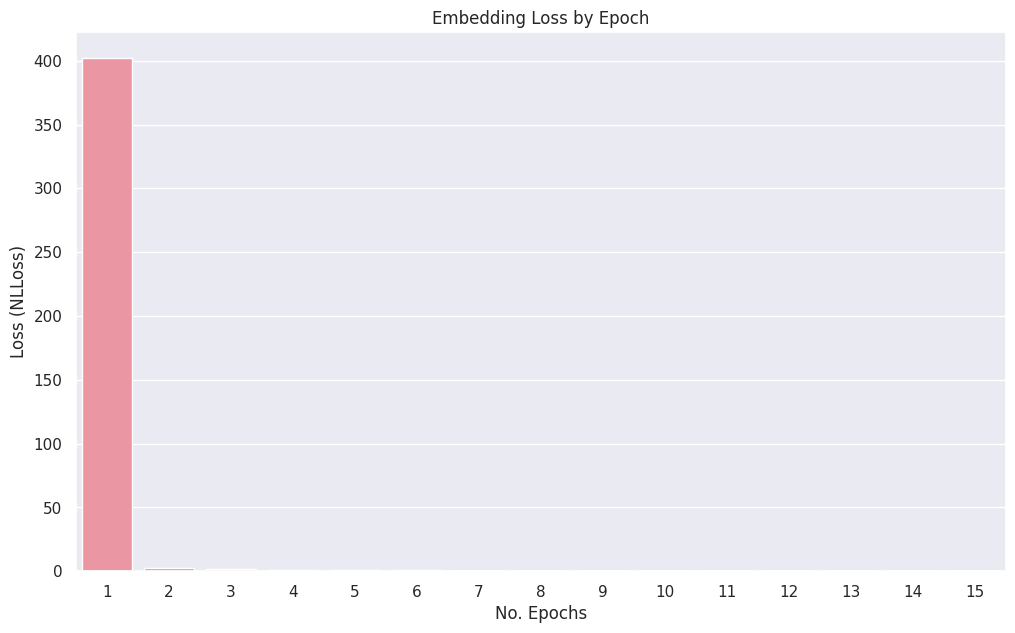

In [304]:
ahl_loss, _ = ahl_avg.charts()

### `CnnExSbert`

In [ ]:
class SbertCnn(nn.Module):
        
    def __init__(self, *, 
        text_max : int, 
        sentence_max : int, 
        layers : int, 
        embedding_size : int
    ):
        super(SbertCnn, self).__init__()
        
        self.activate = nn.Sequential(
            nn.Conv2d(layers, sentence_max, kernel_size=3, padding=1),
            nn.ReLU(), 
            nn.Conv2d(sentence_max, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Flatten(), 
            
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 384),
            nn.LeakyReLU(),
            nn.Flatten(0),
            nn.Unflatten(0, (384, 128)),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, inputs):
        return self.activate(inputs)

In [ ]:
class CnnExSbert(Pap2Pat):
  def __init__(self):
    self.arxiv_tokens_pd = arxiv_tokens_pd[
        ["id", "abstract_ne"]
    ]
    self.arxiv_tokens_pd["which"] = "paper"
    self.patent_tokens_pd = patent_tokens_pd[
        ["application_number", "abstract_ne"]
    ]
    self.patent_tokens_pd.rename({ 
        "application_number" : "id"
    })
    self.patent_tokens_pd["which"] = "patent"

  def encode_sentence(self, text : str)->torch.TensorType:
        fliced = flice_text(text, max_length=self.sentence_max, fill_str=" ")
        ascii_nums = [ord(c) for c in fliced]
        return torch.FloatTensor(ascii_nums)
    
  def encode_input(self, text : str)->torch.TensorType:
      fliced = flice_list(
          [
            self.encode_sentence(sentence)
            for sentence in tokenize_sentences(text)
          ],
          max_length=self.text_max,
          fill_term=[x for x in range(0, self.sentence_max)]
      )
  
      t = torch.stack([
          torch.FloatTensor(entry)
          for entry in fliced
      ])
      
      return torch.stack([
          t,
          torch.roll(t, 1, 0),
          torch.roll(t, -1, 0)
      ])
    
  def compute_label(self, text : str)->torch.TensorType: 
        sentences = tokenize_sentences(text)
        encoding = self.sbert.encode(sentences)
        return torch.from_numpy(np.average(encoding, axis=0))

  def train(self):

    combined = pd.concat([
        self.arxiv_tokens_pd,
        self.patent_tokens_pd
    ])

    self.recommender_table = build_graph_df(
        combined,
        combined,
        "abstract_ne"
    )

  def compute_cosine_sims(self, df : pd.DataFrame, id : str):
    sim = nn.CosineSimilarity()
    values, indices = sim(df[df["id" == id]]["aemb"].loc[0], torch.stack([
        df["aemb"]
    ])).sort(descending=True)
    return (values, indices)

  def compute_top_n_cosine(self, df : pd.DataFrame, id : str, n : int):
    values, indices = self.compute_cosine_sims(df, id)
    top_indices = indices[0:n]
    return df.iloc[top_indices]

  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    df = df[
        (df["id_x"] == paper_id) 
        & (df["which_y"] == "patent")
    ]
    return self.compute_to_n_cosine(df, id, self.size)

  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    df = df[
        (df["id_x"] == paper_id) 
        & (df["which_y"] == "paper")
    ]
    return self.compute_to_n_cosine(df, id, self.size)

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    df = df[
        (df["id_x"] == patent_id) 
        & (df["which_y"] == "paper")
    ]
    return self.compute_to_n_cosine(df, id, self.size)

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    df = df[
        (df["id_x"] == patent_id) 
        & (df["which_y"] == "patent")
    ]
    return self.compute_to_n_cosine(df, id, self.size)

The above is too large to reasonably include in this colab notebook, especially considering we are usually at max RAM by this point.

### Conclusions

That's a wrap! In this notebook, we walked you through our exploration of publically available paper and patent data, and matching between the two. While we endeavored in many powerful natural languae processing techniques, we ultimately discovered that processing this large data well enough to build powerful mo models was quite difficult. We did, however, produce a compelling recommendation model. 

To see more of our efforts and exploration, check out our GitHub repo: https://github.com/ahl-big-data/ahl

For as long as it's affordable, we intend to host a toy version of our models at https://pap2pat.com . That may not be very long, however!